# Pemodelan Machine Learning Tes Data Scientist RuangGuru

Dalam pemodelan ini terdapat beberapa tahapan yang akan dilalui yaitu :
* __1.Data Processing__
* __2.Feature Selection__
* __3.Modelling & Optimization__
* __4.Model Interpretability__
* __5.Backtest on 'Data Testing' (out of sample)__

# Importing Libraries for Data Processing

In [753]:
#import Counter from collections
from collections import Counter
import collections
from tqdm import tqdm

# %%
import warnings
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from xverse.ensemble import VotingSelector

pd.options.display.max_columns=999
pd.options.display.max_rows = 999

## KONFIGURASI PANDAS DAN PLOT ##
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.option_context("display.max_rows", 100)

# set the style of the axes and the text color
plt.rcParams['figure.figsize'] = (12.0, 5.0)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("paper")
sns.set_palette("bright")

# Import Required Dataset

In [754]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
sub_example=pd.read_csv('submission_example.csv')

### Make all letter in column 'question_type' to lower case

In [755]:
data_train['question_type']=data_train['question_type'].str.lower()

# 1. Data Processing

## 1.1. Feature Engineering 1

### 1.1.1 Setiap baris ditambah kolom (hasil feature engineering 1) :
* __is_same_session__ = mengecek apakah row tersebut termasuk dalam session yang sama.
* __is_new_topic__ = mengecek apakah row tersebut termasuk kedalam topik yang baru.
* __is_new_subtopic__ = mengecek apakah row tersebut termasuk kedalam sub-topik yang baru.
* __is_new_learningnode__ = mengecek apakah row tersebut termasuk kedalam learning node yang baru.
* __is_new_questionid__ = mengecek apakah row tersebut termasuk kedalam question yang baru.
* __n_topic__ = jumlah topik unik yang diambil oleh user_id pada row tersebut. 
* __n_subtopic__ = jumlah sub-topik unik yang diambil oleh user_id pada row tersebut.
* __n_learningnode__ = jumlah learning node unik yang diambil oleh user_id pada row tersebut.
* __n_questionid__ = jumlah questionid unik yang diambil oleh user_id pada row tersebut.


In [249]:
user_id = []
session_id=[]
session_no=[]
topic=[]
sub_topic=[]
learning_node=[]
question_id=[]
question_type=[]
session_question_no=[]
learning_node_question_no=[]
question_difficulty=[]
question_number_of_choice=[]
is_correct=[]

#new columns
#feature engineering

is_new_session_id=[]

is_new_topic=[]
is_new_subtopic=[]
is_new_learningnode=[]
is_new_questionid=[]
is_new_session_question_no=[]
is_new_learning_node_question_no=[]

n_topic=[]
n_subtopic=[]
n_learningnode=[]
n_questionid=[]

#tambahan empty dictionary
session_question = collections.defaultdict(list)
learning_question= collections.defaultdict(list)

for i in tqdm(range(len(data_train.user_id.unique()))):
    df_user = data_train[data_train.user_id==data_train.user_id.unique()[i]]

    for j in range(df_user.shape[0]):
    
        user_id.append(df_user.user_id.iloc[j])
        session_no.append(df_user.session_no.iloc[j])
        
        #is_new_session
        if (df_user.session_id.iloc[j] in session_id):
            is_new_session_id.append(0)
        else:
            is_new_session_id.append(1)
    
        #is_new_topic
        if (df_user.topic.iloc[j] in topic):
            is_new_topic.append(0)
        else:
            is_new_topic.append(1)
        
        #is_new_subtopic
        if (df_user.sub_topic.iloc[j] in sub_topic):
            is_new_subtopic.append(0)
        else:
            is_new_subtopic.append(1)
        
        #is_new_learningnode
        if (df_user.learning_node.iloc[j] in learning_node):
            is_new_learningnode.append(0)
        else:
            is_new_learningnode.append(1)
        
        #is_new_questionid
        if (df_user.question_id.iloc[j] in question_id):
            is_new_questionid.append(0)
        else:
            is_new_questionid.append(1)
    
        #is_new_session_question_no
        key,value = df_user.session_id.iloc[j], df_user.session_question_no.iloc[j]   # Key and value present
        if key in session_question and value in session_question[key]:
            is_new_session_question_no.append(0)
        else:
            is_new_session_question_no.append(1)
        
        #is_new_learning_node_question_no
        key_1,value_1 = df_user.learning_node.iloc[j], df_user.learning_node_question_no.iloc[j]   # Key and value present
        if key_1 in learning_question and value_1 in learning_question[key_1]:
            is_new_learning_node_question_no.append(0)
        else:
            is_new_learning_node_question_no.append(1)
    
        #update dictionary
        session_question[df_user.session_id.iloc[j]].append(df_user.session_question_no.iloc[j])
        learning_question[df_user.learning_node.iloc[j]].append(df_user.learning_node_question_no.iloc[j])
    
        #old columns
        session_id.append(df_user.session_id.iloc[j])
        topic.append(df_user.topic.iloc[j])
        sub_topic.append(df_user.sub_topic.iloc[j])
        learning_node.append(df_user.learning_node.iloc[j])
        question_id.append(df_user.question_id.iloc[j])
        question_type.append(df_user.question_type.iloc[j])
        question_difficulty.append(df_user.question_difficulty.iloc[j])
        session_question_no.append(df_user.session_question_no.iloc[j])
        learning_node_question_no.append(df_user.learning_node_question_no.iloc[j])
        question_number_of_choice.append(df_user.question_number_of_choice.iloc[j])
        is_correct.append(df_user.is_correct.iloc[j])
    
        #n_topic
        n_topic.append(len(Counter(topic).keys()))
        #n_subtopic
        n_subtopic.append(len(Counter(sub_topic).keys()))
        #n_learningnode
        n_learningnode.append(len(Counter(learning_node).keys()))
        #n_questionid
        n_questionid.append(len(Counter(question_id).keys()))
        
pd_cust = pd.DataFrame()
pd_cust['user_id']=user_id
pd_cust['session_id']=session_id
pd_cust['session_no']=session_no
pd_cust['topic']=topic
pd_cust['sub_topic']=sub_topic
pd_cust['learning_node']=learning_node
pd_cust['question_id']=question_id
pd_cust['question_type']=question_type
pd_cust['session_question_no']=session_question_no
pd_cust['learning_node_question_no']=learning_node_question_no
pd_cust['question_number_of_choice']=question_number_of_choice
pd_cust['question_difficulty']= question_difficulty


pd_cust['is_new_session_id']=is_new_session_id
pd_cust['is_new_topic']=is_new_topic
pd_cust['is_new_subtopic']=is_new_subtopic
pd_cust['is_new_learningnode']=is_new_learningnode
pd_cust['is_new_questionid']=is_new_questionid
pd_cust['is_new_session_question_no']= is_new_session_question_no
pd_cust['is_new_learning_node_question_no']=is_new_learning_node_question_no


pd_cust['n_topic']=n_topic
pd_cust['n_subtopic']=n_subtopic
pd_cust['n_learningnode']=n_learningnode
pd_cust['n_questionid']=n_questionid

pd_cust['is_correct']=is_correct

print(pd_cust.shape)
pd_cust

100%|████████████████████████████████████████████████████████████████████████████| 7000/7000 [9:28:09<00:00,  4.87s/it]


(286886, 24)


,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,...,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,n_topic,n_subtopic,n_learningnode,n_questionid,is_correct
0,2348875,5473538500,1.0,1064573894,6164056362,1683819444,2226271822,single choice,1,1,...,1,1,1,1,1,1,1,1,1,0.0
1,2348875,5473538500,1.0,1064573894,6164056362,1683819444,2226271822,single choice,2,2,...,0,0,0,1,1,1,1,1,1,0.0
2,2348875,3206055652,2.0,1064573894,6164056362,1683819444,5592568637,single choice,1,1,...,0,0,1,1,0,1,1,1,2,1.0
3,2766044,9605991415,1.0,4794286044,6471306273,3791168789,1243898418,single choice,1,1,...,1,1,1,1,1,2,2,2,3,1.0
4,2766044,7255460452,2.0,4794286044,2158335016,7856645946,4732798598,single choice,1,1,...,1,1,1,1,1,2,3,3,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286881,9997990646,420822992,56.0,3214173988,5665086549,7850722305,6952257376,single choice,9,1,...,0,0,0,1,0,1639,2265,12093,30653,1.0
286882,9997990646,420822992,56.0,3214173988,5665086549,7850722305,6952257376,single choice,10,2,...,0,0,0,1,0,1639,2265,12093,30653,1.0
286883,9997990646,1033242156,57.0,1667815079,5665086549,4753693868,6160258455,single choice,1,1,...,0,0,0,1,0,1639,2265,12093,30653,1.0
286884,9997990646,1033242156,57.0,1667815079,5665086549,6822762525,3372559174,single choice,2,1,...,0,0,0,1,0,1639,2265,12093,30653,1.0


In [250]:
pd_cust

,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,...,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,n_topic,n_subtopic,n_learningnode,n_questionid,is_correct
0,2348875,5473538500,1.0,1064573894,6164056362,1683819444,2226271822,single choice,1,1,...,1,1,1,1,1,1,1,1,1,0.0
1,2348875,5473538500,1.0,1064573894,6164056362,1683819444,2226271822,single choice,2,2,...,0,0,0,1,1,1,1,1,1,0.0
2,2348875,3206055652,2.0,1064573894,6164056362,1683819444,5592568637,single choice,1,1,...,0,0,1,1,0,1,1,1,2,1.0
3,2766044,9605991415,1.0,4794286044,6471306273,3791168789,1243898418,single choice,1,1,...,1,1,1,1,1,2,2,2,3,1.0
4,2766044,7255460452,2.0,4794286044,2158335016,7856645946,4732798598,single choice,1,1,...,1,1,1,1,1,2,3,3,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286881,9997990646,420822992,56.0,3214173988,5665086549,7850722305,6952257376,single choice,9,1,...,0,0,0,1,0,1639,2265,12093,30653,1.0
286882,9997990646,420822992,56.0,3214173988,5665086549,7850722305,6952257376,single choice,10,2,...,0,0,0,1,0,1639,2265,12093,30653,1.0
286883,9997990646,1033242156,57.0,1667815079,5665086549,4753693868,6160258455,single choice,1,1,...,0,0,0,1,0,1639,2265,12093,30653,1.0
286884,9997990646,1033242156,57.0,1667815079,5665086549,6822762525,3372559174,single choice,2,1,...,0,0,0,1,0,1639,2265,12093,30653,1.0


In [252]:
pd_cust.to_csv('20210814_Dataset_RuangGuru_FeatureEng1.csv')

### 1.1.2 Tambahan fitur turunan dari hasil feature enginering 1

__Binary operation__

* __is_new_session_id_n_new_topic__ = apakah row merupakan new session & new topic
* __is_new_session_id_n_new_subtopic__ = apakah row merupakan new session & new sub-topic
* __is_new_session_id_n_new_learningnode__ = apakah row merupakan new session & new learning node
* __is_new_session_id_n_new_questionid__ = apakah row merupakan new session & new questionid

* __is_new_topic_n_new_subtopic__ = apakah row merupakan new topik & new sub-topic
* __is_new_topic_n_new_learningnode__ = apakah row merupakan new topik & new learning node 
* __is_new_topic_n_new_questionid__ = apakah row merupakan new topik & new questionid

* __is_new_subtopic_n_new_learningnode__ = apakah row merupakan new sub-topik & new learning node 
* __is_new_subtopic_n_new_questionid__ = apakah row merupakan new sub-topik & new questionid

* __is_new_learning_node_n_questionid__ = apakah row merupakan new learning node & new questionid

In [259]:
pd_cust['is_new_session_id_n_new_topic']        = pd_cust['is_new_session_id'] & pd_cust['is_new_topic']
pd_cust['is_new_session_id_n_new_subtopic']     = pd_cust['is_new_session_id'] & pd_cust['is_new_subtopic']
pd_cust['is_new_session_id_n_new_learningnode'] = pd_cust['is_new_session_id'] & pd_cust['is_new_learningnode']
pd_cust['is_new_session_id_n_new_questionid']   = pd_cust['is_new_session_id'] & pd_cust['is_new_questionid']

pd_cust['is_new_topic_n_new_subtopic']          = pd_cust['is_new_topic'] & pd_cust['is_new_subtopic']
pd_cust['is_new_topic_n_new_learningnode']      = pd_cust['is_new_topic'] & pd_cust['is_new_learningnode']
pd_cust['is_new_topic_n_new_questionid']        = pd_cust['is_new_topic'] & pd_cust['is_new_questionid']

pd_cust['is_new_subtopic_n_new_learningnode']   = pd_cust['is_new_subtopic'] & pd_cust['is_new_learningnode']
pd_cust['is_new_subtopic_n_new_questionid']     = pd_cust['is_new_subtopic'] & pd_cust['is_new_questionid']

pd_cust['is_new_learning_node_n_questionid']    = pd_cust['is_new_learningnode'] & pd_cust['is_new_questionid']

In [261]:
pd_cust.to_csv('20210814_Dataset_RuangGuru_FeatureEng2.csv')

## 1.2. Data Cleaning

Ada beberapa hal yang dilakukan pada tahap __Data Cleaning__ :
* 1.Cek Data Null
* 2.Imputasi Data Null(mean, mode)
* 3.One-hot encoding fitur question_type & question_difficulty (opsional : question_no_of_choice)
* 4.Drop fitur __'session_id__, __topic__, __sub_topic__, __learning_node__, __question_id__, __question_type__, __question_difficulty__, __question_number_of_correct_choice__,
__question_number_of_correct_selected__,
__question_number_of_wrong_selected__, __ms_first_response__, __row_id'__.
* 5.Fitur __'question_number_of_correct_choice, question_number_of_correct_selected'__ di __drop__, diduga akan membuat kebocoran data, karena erat kaitannya dengan pembuatan target data(label).
			

In [359]:
data_train = pd.read_csv('20210814_Dataset_RuangGuru_FeatureEng2.csv')
data_train

,Unnamed: 0,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,question_number_of_choice,question_difficulty,is_new_session_id,is_new_topic,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,n_topic,n_subtopic,n_learningnode,n_questionid,is_correct,is_new_session_id_n_new_topic,is_new_session_id_n_new_subtopic,is_new_session_id_n_new_learningnode,is_new_session_id_n_new_questionid,is_new_topic_n_new_subtopic,is_new_topic_n_new_learningnode,is_new_topic_n_new_questionid,is_new_subtopic_n_new_learningnode,is_new_subtopic_n_new_questionid,is_new_learning_node_n_questionid
0,0,2348875,5473538500,1.0,1064573894,6164056362,1683819444,2226271822,single choice,1,1,4,medium,1,1,1,1,1,1,1,1,1,1,1,0.0,1,1,1,1,1,1,1,1,1,1
1,1,2348875,5473538500,1.0,1064573894,6164056362,1683819444,2226271822,single choice,2,2,4,medium,0,0,0,0,0,1,1,1,1,1,1,0.0,0,0,0,0,0,0,0,0,0,0
2,2,2348875,3206055652,2.0,1064573894,6164056362,1683819444,5592568637,single choice,1,1,4,medium,1,0,0,0,1,1,0,1,1,1,2,1.0,0,0,0,1,0,0,0,0,0,0
3,3,2766044,9605991415,1.0,4794286044,6471306273,3791168789,1243898418,single choice,1,1,4,medium,1,1,1,1,1,1,1,2,2,2,3,1.0,1,1,1,1,1,1,1,1,1,1
4,4,2766044,7255460452,2.0,4794286044,2158335016,7856645946,4732798598,single choice,1,1,4,medium,1,0,1,1,1,1,1,2,3,3,4,1.0,0,1,1,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286881,286881,9997990646,420822992,56.0,3214173988,5665086549,7850722305,6952257376,single choice,9,1,3,NaN,0,0,0,0,0,1,0,1639,2265,12093,30653,1.0,0,0,0,0,0,0,0,0,0,0
286882,286882,9997990646,420822992,56.0,3214173988,5665086549,7850722305,6952257376,single choice,10,2,3,NaN,0,0,0,0,0,1,0,1639,2265,12093,30653,1.0,0,0,0,0,0,0,0,0,0,0
286883,286883,9997990646,1033242156,57.0,1667815079,5665086549,4753693868,6160258455,single choice,1,1,3,NaN,1,0,0,0,0,1,0,1639,2265,12093,30653,1.0,0,0,0,0,0,0,0,0,0,0
286884,286884,9997990646,1033242156,57.0,1667815079,5665086549,6822762525,3372559174,single choice,2,1,3,NaN,0,0,0,0,0,1,0,1639,2265,12093,30653,1.0,0,0,0,0,0,0,0,0,0,0


### 1.2.1 Cek Data Null

<AxesSubplot:title={'center':'Kolom yang memiliki Null(1/24)'}>

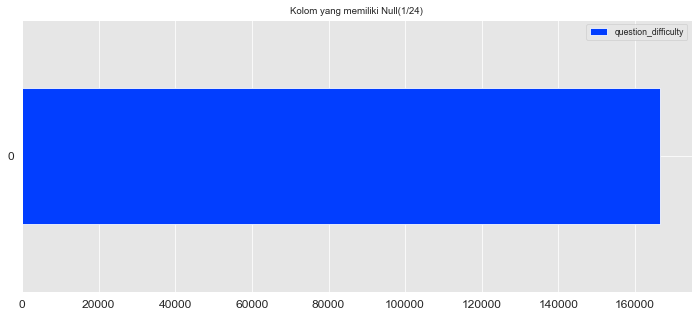

In [360]:
#hitung jumlah NULL dalam setiap kolom
# Count total NaN at each column in a DataFrame 
data_null = pd.DataFrame(data_train.isnull().sum())
data_null = data_null.transpose()
data_null_filter=data_null.loc[:, (data_null != 0).any(axis=0)]
data_null_filter.plot(kind='barh',title='Kolom yang memiliki Null(1/24)',fontsize=12)

In [361]:
data_null

,Unnamed: 0,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,question_number_of_choice,question_difficulty,is_new_session_id,is_new_topic,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,n_topic,n_subtopic,n_learningnode,n_questionid,is_correct,is_new_session_id_n_new_topic,is_new_session_id_n_new_subtopic,is_new_session_id_n_new_learningnode,is_new_session_id_n_new_questionid,is_new_topic_n_new_subtopic,is_new_topic_n_new_learningnode,is_new_topic_n_new_questionid,is_new_subtopic_n_new_learningnode,is_new_subtopic_n_new_questionid,is_new_learning_node_n_questionid
0,0,0,0,0,0,0,0,0,0,0,0,0,166513,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 1.2.2. Imputasi Data kategorial 'question_difficulty' yang bernilai Null dengan nilai modusnya nya

In [362]:
data_train['question_difficulty'].fillna('medium', inplace=True)

In [363]:
data_train['question_difficulty'].value_counts()

medium    280320
easy        4855
hard        1237
hots         474
Name: question_difficulty, dtype: int64

In [364]:
data_train.isnull().sum()

Unnamed: 0                              0
user_id                                 0
session_id                              0
session_no                              0
topic                                   0
sub_topic                               0
learning_node                           0
question_id                             0
question_type                           0
session_question_no                     0
learning_node_question_no               0
question_number_of_choice               0
question_difficulty                     0
is_new_session_id                       0
is_new_topic                            0
is_new_subtopic                         0
is_new_learningnode                     0
is_new_questionid                       0
is_new_session_question_no              0
is_new_learning_node_question_no        0
n_topic                                 0
n_subtopic                              0
n_learningnode                          0
n_questionid                      

### 1.2.3 One-Hot Encoding fitur kategorikal

In [365]:
data_train.head()

,Unnamed: 0,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,question_number_of_choice,question_difficulty,is_new_session_id,is_new_topic,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,n_topic,n_subtopic,n_learningnode,n_questionid,is_correct,is_new_session_id_n_new_topic,is_new_session_id_n_new_subtopic,is_new_session_id_n_new_learningnode,is_new_session_id_n_new_questionid,is_new_topic_n_new_subtopic,is_new_topic_n_new_learningnode,is_new_topic_n_new_questionid,is_new_subtopic_n_new_learningnode,is_new_subtopic_n_new_questionid,is_new_learning_node_n_questionid
0,0,2348875,5473538500,1.0,1064573894,6164056362,1683819444,2226271822,single choice,1,1,4,medium,1,1,1,1,1,1,1,1,1,1,1,0.0,1,1,1,1,1,1,1,1,1,1
1,1,2348875,5473538500,1.0,1064573894,6164056362,1683819444,2226271822,single choice,2,2,4,medium,0,0,0,0,0,1,1,1,1,1,1,0.0,0,0,0,0,0,0,0,0,0,0
2,2,2348875,3206055652,2.0,1064573894,6164056362,1683819444,5592568637,single choice,1,1,4,medium,1,0,0,0,1,1,0,1,1,1,2,1.0,0,0,0,1,0,0,0,0,0,0
3,3,2766044,9605991415,1.0,4794286044,6471306273,3791168789,1243898418,single choice,1,1,4,medium,1,1,1,1,1,1,1,2,2,2,3,1.0,1,1,1,1,1,1,1,1,1,1
4,4,2766044,7255460452,2.0,4794286044,2158335016,7856645946,4732798598,single choice,1,1,4,medium,1,0,1,1,1,1,1,2,3,3,4,1.0,0,1,1,1,0,0,0,1,1,1


In [366]:
question_type        = pd.get_dummies(data_train.question_type, prefix='question_type')
question_difficulty  = pd.get_dummies(data_train.question_difficulty, prefix='question_difficulty')

In [367]:
data_train = pd.concat([data_train, question_type], axis=1)
data_train = pd.concat([data_train, question_difficulty], axis=1)

In [368]:
data_train.head()

,Unnamed: 0,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,question_number_of_choice,question_difficulty,is_new_session_id,is_new_topic,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,n_topic,n_subtopic,n_learningnode,n_questionid,is_correct,is_new_session_id_n_new_topic,is_new_session_id_n_new_subtopic,is_new_session_id_n_new_learningnode,is_new_session_id_n_new_questionid,is_new_topic_n_new_subtopic,is_new_topic_n_new_learningnode,is_new_topic_n_new_questionid,is_new_subtopic_n_new_learningnode,is_new_subtopic_n_new_questionid,is_new_learning_node_n_questionid,question_type_multi choice,question_type_single choice,question_difficulty_easy,question_difficulty_hard,question_difficulty_hots,question_difficulty_medium
0,0,2348875,5473538500,1.0,1064573894,6164056362,1683819444,2226271822,single choice,1,1,4,medium,1,1,1,1,1,1,1,1,1,1,1,0.0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1
1,1,2348875,5473538500,1.0,1064573894,6164056362,1683819444,2226271822,single choice,2,2,4,medium,0,0,0,0,0,1,1,1,1,1,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,2,2348875,3206055652,2.0,1064573894,6164056362,1683819444,5592568637,single choice,1,1,4,medium,1,0,0,0,1,1,0,1,1,1,2,1.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,3,2766044,9605991415,1.0,4794286044,6471306273,3791168789,1243898418,single choice,1,1,4,medium,1,1,1,1,1,1,1,2,2,2,3,1.0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1
4,4,2766044,7255460452,2.0,4794286044,2158335016,7856645946,4732798598,single choice,1,1,4,medium,1,0,1,1,1,1,1,2,3,3,4,1.0,0,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1


### 1.2.3. Drop Unnecassary Columns

In [369]:
data_train = data_train.drop(['Unnamed: 0','session_id', 'topic', 'sub_topic', 
                              'learning_node', 'question_id', 'question_type',
                              'question_difficulty'] ,axis=1)

In [372]:
data_train.columns

Index(['user_id', 'session_no', 'session_question_no',
       'learning_node_question_no', 'question_number_of_choice',
       'is_new_session_id', 'is_new_topic', 'is_new_subtopic',
       'is_new_learningnode', 'is_new_questionid',
       'is_new_session_question_no', 'is_new_learning_node_question_no',
       'n_topic', 'n_subtopic', 'n_learningnode', 'n_questionid', 'is_correct',
       'is_new_session_id_n_new_topic', 'is_new_session_id_n_new_subtopic',
       'is_new_session_id_n_new_learningnode',
       'is_new_session_id_n_new_questionid', 'is_new_topic_n_new_subtopic',
       'is_new_topic_n_new_learningnode', 'is_new_topic_n_new_questionid',
       'is_new_subtopic_n_new_learningnode',
       'is_new_subtopic_n_new_questionid', 'is_new_learning_node_n_questionid',
       'question_type_multi choice', 'question_type_single choice',
       'question_difficulty_easy', 'question_difficulty_hard',
       'question_difficulty_hots', 'question_difficulty_medium'],
      dtype='obje

In [374]:
data_train.to_csv('20210815_Dataset_RuangGuru_FeatureEng2_cleaned.csv')

## 1.3 Feature Engineering 2

### 1.3.1 Perbaikan kolom n_topic, n_subtopic, n_learningnode, n_questionid

__Tambahan fitur baru pada Feature Engineering 2__ :

* __prob_correct__  = peluang row tersebut untuk benar (jumlah jawaban benar / jumlah jawaban. tersedia).
* __n_prob_correct__= peluang row tersebut untuk benar setiap terjadi perulangan soal (semakin seorang user mengambil soal yang sama peluang benar semakin besar).

In [ ]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
sub_example=pd.read_csv('submission_example.csv')
data_train['question_type']=data_train['question_type'].str.lower()

In [ ]:
user_id = []
session_id=[]
session_no=[]
topic=[]
sub_topic=[]
learning_node=[]
question_id=[]
question_type=[]
session_question_no=[]
learning_node_question_no=[]
question_difficulty=[]
question_number_of_choice=[]
question_number_of_correct_choice=[]
is_correct=[]

#tambahan empty dictionary
n_topic_dict = collections.defaultdict(list)
n_subtopic_dict = collections.defaultdict(list)
n_learningnode_dict = collections.defaultdict(list)
n_questionid_dict = collections.defaultdict(list)
n_prob_correct_dict= collections.defaultdict(list)

n_topic=[]
n_subtopic=[]
n_learningnode=[]
n_questionid=[]
prob_correct=[]
n_prob_correct=[]

#for i in tqdm(range(5)):
for i in tqdm(range(len(data_train.user_id.unique()))):
    df_user = data_train[data_train.user_id==data_train.user_id.unique()[i]]

    for j in range(df_user.shape[0]):
    
        user_id.append(df_user.user_id.iloc[j])
        session_no.append(df_user.session_no.iloc[j])
    
        #old columns
        session_id.append(df_user.session_id.iloc[j])
        topic.append(df_user.topic.iloc[j])
        sub_topic.append(df_user.sub_topic.iloc[j])
        learning_node.append(df_user.learning_node.iloc[j])
        question_id.append(df_user.question_id.iloc[j])
        question_type.append(df_user.question_type.iloc[j])
        question_difficulty.append(df_user.question_difficulty.iloc[j])
        session_question_no.append(df_user.session_question_no.iloc[j])
        learning_node_question_no.append(df_user.learning_node_question_no.iloc[j])
        question_number_of_choice.append(df_user.question_number_of_choice.iloc[j])
        question_number_of_correct_choice.append(df_user.question_number_of_correct_choice.iloc[j])
        is_correct.append(df_user.is_correct.iloc[j])
    
        #n_topic
        key,value = df_user.user_id.iloc[j], df_user.topic.iloc[j]   # Key and value present
        if key not in  n_topic_dict and value not in  n_topic_dict[key]:
            n_topic.append(1)
            
        elif key in  n_topic_dict and value not in  n_topic_dict[key]:
            n_topic.append(len(Counter(n_topic_dict[key]).keys())+1)
        
        elif key in  n_topic_dict and value in  n_topic_dict[key]:
            n_topic.append(len(Counter(n_topic_dict[key]).keys()))
            
        #n_subtopic
        key1,value1 = df_user.user_id.iloc[j], df_user.sub_topic.iloc[j]   # Key and value present
        if key1 not in  n_subtopic_dict and value1 not in  n_subtopic_dict[key1]:
            n_subtopic.append(1)
            
        elif key1 in  n_subtopic_dict and value1 not in  n_subtopic_dict[key1]:
            n_subtopic.append(len(Counter(n_subtopic_dict[key1]).keys())+1)
        
        elif key1 in  n_subtopic_dict and value1 in  n_subtopic_dict[key1]:
            n_subtopic.append(len(Counter(n_subtopic_dict[key1]).keys()))
            
        #n_learningnode
        key2,value2 = df_user.user_id.iloc[j], df_user.learning_node.iloc[j]   # Key and value present
        if key2 not in  n_learningnode_dict and value2 not in  n_learningnode_dict[key2]:
            n_learningnode.append(1)
            
        elif key2 in  n_learningnode_dict and value2 not in  n_learningnode_dict[key2]:
            n_learningnode.append(len(Counter(n_learningnode_dict[key2]).keys())+1)
        
        elif key2 in  n_learningnode_dict and value2 in  n_learningnode_dict[key2]:
            n_learningnode.append(len(Counter(n_learningnode_dict[key2]).keys()))
            
        #n_questionid
        key3,value3 = df_user.user_id.iloc[j], df_user.question_id.iloc[j]   # Key and value present
        if key3 not in  n_questionid_dict and value3 not in  n_questionid_dict[key3]:
            n_questionid.append(1)
            
        elif key3 in  n_questionid_dict and value3 not in  n_questionid_dict[key3]:
            n_questionid.append(len(Counter(n_questionid_dict[key3]).keys())+1)
        
        elif key3 in  n_questionid_dict and value3 in  n_questionid_dict[key3]:
            n_questionid.append(len(Counter(n_questionid_dict[key3]).keys()))
            
        #n_prob_correct
        key4,value4 = df_user.user_id.iloc[j], df_user.question_id.iloc[j]   # Key and value present
        if key4 not in n_prob_correct_dict and value4 not in  n_prob_correct_dict[key4]:
            n_prob_correct.append(df_user.question_number_of_correct_choice.iloc[j]/df_user.question_number_of_choice.iloc[j])
            
        elif key4 in n_prob_correct_dict and value4 not in n_prob_correct_dict[key4]:
            n_prob_correct.append(df_user.question_number_of_correct_choice.iloc[j]/df_user.question_number_of_choice.iloc[j])
        
        elif key4 in  n_prob_correct_dict and value4 in  n_prob_correct_dict[key4]:
            temp_list =  n_prob_correct_dict[key4]
            n_prob_correct.append((temp_list.count(df_user.question_id.iloc[j])+1)/df_user.question_number_of_choice.iloc[j])    
            
        #prob_correct
        prob_correct.append(df_user.question_number_of_correct_choice.iloc[j]/df_user.question_number_of_choice.iloc[j])
        
        #update dictionary
        n_topic_dict[df_user.user_id.iloc[j]].append(df_user.topic.iloc[j])
        n_subtopic_dict[df_user.user_id.iloc[j]].append(df_user.sub_topic.iloc[j])
        n_learningnode_dict[df_user.user_id.iloc[j]].append(df_user.learning_node.iloc[j])
        n_questionid_dict[df_user.user_id.iloc[j]].append(df_user.question_id.iloc[j])
        n_prob_correct_dict[df_user.user_id.iloc[j]].append(df_user.question_id.iloc[j])
        
        
pd_cust = pd.DataFrame()
pd_cust['user_id']=user_id
pd_cust['session_id']=session_id
pd_cust['session_no']=session_no
pd_cust['topic']=topic
pd_cust['sub_topic']=sub_topic
pd_cust['learning_node']=learning_node
pd_cust['question_id']=question_id
pd_cust['question_type']=question_type
pd_cust['session_question_no']=session_question_no
pd_cust['learning_node_question_no']=learning_node_question_no
pd_cust['question_number_of_choice']=question_number_of_choice
pd_cust['question_difficulty']= question_difficulty

pd_cust['n_topic']=n_topic
pd_cust['n_subtopic']=n_subtopic
pd_cust['n_learningnode']=n_learningnode
pd_cust['n_questionid']=n_questionid
pd_cust['prob_correct']=prob_correct
pd_cust['n_prob_correct']=n_prob_correct

pd_cust['is_correct']=is_correct

print(pd_cust.shape)
pd_cust

In [ ]:
#data_initial = pd.read_csv('20210815_Dataset_RuangGuru_FeatureEng2_cleaned.csv')
#data_initial = data_initial.drop(['n_topic','n_subtopic','n_learningnode','n_questionid'] ,axis=1)
#data_initial

In [ ]:
data_initial = pd.read_csv('20210815_Dataset_RuangGuru_FeatureEng2_cleaned.csv')
data_initial = data_initial.drop(['n_topic','n_subtopic','n_learningnode','n_questionid'] ,axis=1)
data_initial
list_n_topic = pd_cust.n_topic.tolist()
list_n_subtopic = pd_cust.n_subtopic.tolist()
list_n_learningnode = pd_cust.n_learningnode.tolist()
list_n_questionid = pd_cust.n_questionid.tolist()
list_prob_correct = pd_cust.prob_correct.tolist()
list_n_prob_correct = pd_cust.n_prob_correct.tolist()
data_initial['n_topic']=list_n_topic
data_initial['n_subtopic']=list_n_subtopic
data_initial['n_learningnode']=list_n_learningnode
data_initial['n_questionid']=list_n_questionid
data_initial['prob_correct']=list_prob_correct
data_initial['n_prob_correct']=list_n_prob_correct
data_initial.to_csv('20210815_Dataset_RuangGuru_FeatureEng2_cleaned_newver.csv')

In [ ]:
'''
data_initial['n_topic']=list_n_topic
data_initial['n_subtopic']=list_n_subtopic
data_initial['n_learningnode']=list_n_learningnode
data_initial['n_questionid']=list_n_questionid
data_initial['prob_correct']=list_prob_correct
data_initial['n_prob_correct']=list_n_prob_correct
data_initial
'''

In [ ]:
data_initial.to_csv('20210815_Dataset_RuangGuru_FeatureEng2_cleaned_newver.csv')

 __Gunakan data hasil feature engineering 2__

In [803]:
data_train = pd.read_csv('20210815_Dataset_RuangGuru_FeatureEng2_cleaned_newver.csv')

In [804]:
data_train.head()

,Unnamed: 0,Unnamed: 0.1,user_id,session_no,session_question_no,learning_node_question_no,question_number_of_choice,is_new_session_id,is_new_topic,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,is_correct,is_new_session_id_n_new_topic,is_new_session_id_n_new_subtopic,is_new_session_id_n_new_learningnode,is_new_session_id_n_new_questionid,is_new_topic_n_new_subtopic,is_new_topic_n_new_learningnode,is_new_topic_n_new_questionid,is_new_subtopic_n_new_learningnode,is_new_subtopic_n_new_questionid,is_new_learning_node_n_questionid,question_type_multi choice,question_type_single choice,question_difficulty_easy,question_difficulty_hard,question_difficulty_hots,question_difficulty_medium,n_topic,n_subtopic,n_learningnode,n_questionid,prob_correct,n_prob_correct
0,0,0,2348875,1.0,1,1,4,1,1,1,1,1,1,1,0.0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.25,0.25
1,1,1,2348875,1.0,2,2,4,0,0,0,0,0,1,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0.25,0.50
2,2,2,2348875,2.0,1,1,4,1,0,0,0,1,1,0,1.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,2,0.25,0.25
3,3,3,2766044,1.0,1,1,4,1,1,1,1,1,1,1,1.0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.25,0.25
4,4,4,2766044,2.0,1,1,4,1,0,1,1,1,1,1,1.0,0,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1,2,2,2,0.25,0.25


## 1.4 Split Dataset into data training & data test for modelling

In [805]:
# %%
from sklearn.model_selection import train_test_split
## SPLIT DATASET INTO DATA TRAIN AND DATA TEST
data_train, data_test = train_test_split(data_train, test_size=0.30, random_state=24)

data_train.to_csv("%s_Dataset_RuangGuru_FeatureEng2_cleaned_train.csv" % str(date.today().strftime("%Y%m%d")), index=False)
data_test.to_csv("%s_Dataset_RuangGuru_FeatureEng2_cleaned_test.csv" % str(date.today().strftime("%Y%m%d")), index=False)


# 2. Feature Selection
Ada 3 teknik feature selection yang digunakan:
* __Voting Selection__
* __IV & WoE__
* __Cross Correlation(Spearman)__

In [806]:
df_train = pd.read_csv('20210815_Dataset_RuangGuru_FeatureEng2_cleaned_newver.csv')
df_train.head()

,Unnamed: 0,Unnamed: 0.1,user_id,session_no,session_question_no,learning_node_question_no,question_number_of_choice,is_new_session_id,is_new_topic,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,is_correct,is_new_session_id_n_new_topic,is_new_session_id_n_new_subtopic,is_new_session_id_n_new_learningnode,is_new_session_id_n_new_questionid,is_new_topic_n_new_subtopic,is_new_topic_n_new_learningnode,is_new_topic_n_new_questionid,is_new_subtopic_n_new_learningnode,is_new_subtopic_n_new_questionid,is_new_learning_node_n_questionid,question_type_multi choice,question_type_single choice,question_difficulty_easy,question_difficulty_hard,question_difficulty_hots,question_difficulty_medium,n_topic,n_subtopic,n_learningnode,n_questionid,prob_correct,n_prob_correct
0,0,0,2348875,1.0,1,1,4,1,1,1,1,1,1,1,0.0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.25,0.25
1,1,1,2348875,1.0,2,2,4,0,0,0,0,0,1,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0.25,0.50
2,2,2,2348875,2.0,1,1,4,1,0,0,0,1,1,0,1.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,2,0.25,0.25
3,3,3,2766044,1.0,1,1,4,1,1,1,1,1,1,1,1.0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.25,0.25
4,4,4,2766044,2.0,1,1,4,1,0,1,1,1,1,1,1.0,0,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1,2,2,2,0.25,0.25


## 2.1 Voting Selection('WoE', 'RF', 'RFE', 'ETC', 'CS', 'L_One)

In [807]:
#split data into independent features and target 
X = df_train.drop('is_correct',axis = 1)
y = df_train.is_correct

In [808]:
clf = VotingSelector()
clf.fit(X, y)

VotingSelector(no_of_features=18,
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [809]:
#Look at the feature importance
clf.feature_importances_

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Extra_Trees,Chi_Square,L_One
0,n_prob_correct,0.255185,0.053338,5.640826e-20,0.053516,334.944717,6.333524e-02
1,question_number_of_choice,0.195478,0.013227,1.101411e-19,0.017175,667.731857,-1.035315e-01
2,prob_correct,0.195478,0.012978,1.300895e-20,0.016752,817.465649,1.778436e+00
3,is_new_questionid,0.054241,0.005380,-4.764763e-21,0.007429,3357.195142,-1.823212e-01
4,n_topic,0.038942,0.044921,2.410533e-18,0.049762,298.813266,2.144648e-03
5,session_no,0.036142,0.072898,5.293139e-18,0.081511,284.801273,-5.929685e-04
6,n_learningnode,0.036089,0.088166,8.691602e-18,0.092377,230.516409,4.347986e-04
7,n_questionid,0.035793,0.105482,1.454357e-17,0.108217,218.488670,-4.691244e-05
8,is_new_learning_node_question_no,0.030352,0.003692,0.000000e+00,0.003720,1949.702144,-9.468644e-02
9,is_new_learning_node_n_questionid,0.021645,0.000796,0.000000e+00,0.000917,1445.917212,2.545692e-02


In [810]:
hasil_voting = clf.feature_votes_
hasil_voting

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Extra_Trees,Chi_Square,L_One,Votes
0,n_prob_correct,1,1,1,1,1,1,6
2,prob_correct,1,1,1,1,1,1,6
3,is_new_questionid,1,1,1,1,1,1,6
4,n_topic,1,1,1,1,1,1,6
5,session_no,1,1,1,1,1,1,6
6,n_learningnode,1,1,1,1,1,1,6
7,n_questionid,1,1,1,1,1,1,6
1,question_number_of_choice,1,1,1,1,1,1,6
16,learning_node_question_no,1,1,1,1,0,1,5
8,is_new_learning_node_question_no,1,1,0,1,1,1,5


__Fitur Terpilih__

In [811]:
# Ambil hasil transform dengan nilai voting > 3
hasil_voting_filtered = hasil_voting.loc[hasil_voting['Votes'] >= 2]
list_column_voted = hasil_voting_filtered.Variable_Name.tolist()

list_column_voted

['n_prob_correct',
 'prob_correct',
 'is_new_questionid',
 'n_topic',
 'session_no',
 'n_learningnode',
 'n_questionid',
 'question_number_of_choice',
 'learning_node_question_no',
 'is_new_learning_node_question_no',
 'session_question_no',
 'n_subtopic',
 'is_new_session_id',
 'question_difficulty_easy',
 'Unnamed: 0.1',
 'Unnamed: 0',
 'user_id',
 'question_difficulty_medium',
 'is_new_learning_node_n_questionid',
 'is_new_session_id_n_new_questionid',
 'is_new_session_id_n_new_learningnode',
 'is_new_session_question_no',
 'is_new_learningnode',
 'question_type_single choice',
 'is_new_subtopic_n_new_learningnode',
 'is_new_subtopic_n_new_questionid',
 'is_new_subtopic']

 ## 2.2 IV -WoE

In [812]:
def get_information_values(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    data_iv, data_woe = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp = pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        data_iv = pd.concat([data_iv, temp], axis=0)
        data_woe = pd.concat([data_woe, d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)

    return data_iv, data_woe

In [813]:
iv_res, woe_res = get_information_values(df_train, target='is_correct')

Information value of Unnamed: 0 is 0.016125
Information value of Unnamed: 0.1 is 0.016125
Information value of user_id is 0.016555
Information value of session_no is 0.042694
Information value of session_question_no is 0.005906
Information value of learning_node_question_no is 0.003845
Information value of question_number_of_choice is 0.195502
Information value of is_new_session_id is 0.000506
Information value of is_new_topic is 0.001684
Information value of is_new_subtopic is 0.005176
Information value of is_new_learningnode is 0.021629
Information value of is_new_questionid is 0.054241
Information value of is_new_session_question_no is 4.3e-05
Information value of is_new_learning_node_question_no is 0.030352
Information value of is_new_session_id_n_new_topic is 0.001684
Information value of is_new_session_id_n_new_subtopic is 0.001559
Information value of is_new_session_id_n_new_learningnode is 0.005043
Information value of is_new_session_id_n_new_questionid is 0.009554
Information 

In [814]:
woe_res.groupby('Variable').agg('sum').to_csv('iv_and_woe_456_filtered.csv', index=True)

__Fitur Terpilih 0.02<=IV<=0.5__

In [815]:
iv_res[(iv_res.IV <= 0.5) & (iv_res.IV >= 0.02)].sort_values('IV', ascending=False)

,Variable,IV
0,n_prob_correct,0.312224
0,prob_correct,0.195502
0,question_number_of_choice,0.195502
0,is_new_questionid,0.054241
0,n_topic,0.043857
0,session_no,0.042694
0,n_questionid,0.042605
0,n_learningnode,0.042483
0,is_new_learning_node_question_no,0.030352
0,is_new_learning_node_n_questionid,0.021645


## 2.3 Cross - Correlation - Spearman

In [816]:
def cross_corr_mean(df_input, corr_coeff, savefile=1):
    """ The function retuns a list of features to be dropped from the input features.
    
    INPUTS:
    1. df_input: n input features (pandas dataframe)
    2. corr_coeff: Coefficient threshold (absolute value, no negatives) for a pair of variables above which one of the two will be dropped
    3. plot: If set to 1 a plot will be displayed showing a heatmap of the cross-correlation between variables 
    4. savefile: If set to 1, all relevant files will be saved
    
    PLEASE NOTE:
    - The dataframe df_input (should contain only the n input features i.e. no ID and targets) 
    
    SUMMARY OF LOGIC:
    1. The n input variables are taken and a n X n matrix of correlation is created (these are absolute values i.e. a correlation of -0.8 is treated as 0.8)
    2. Variable pairs with correlation higher than the corr_coeff threshold are picked and one of the two variables will be dropped
    3. Which of the two will be dropped is based on the one having lower mean absolute correlation with all other variables 

    SAVED FILES:
    If savefile is set to 1. Saved under current directory under cross_corr_target under folder with a UTC timestamp.
    1. A PDF heatmap representing the cross correlation between all the input features
    2. A CSV of the matrix containing the values used for the heatmap
    3. A CSV of the list of variables to be dropped
    """
        # Pre-processing
    import pandas as pd
    if savefile == 1:
        from datetime import datetime
        time = str(datetime.utcnow())
        import os
        path = str(os.getcwd()) + "/cross_corr_mean/" + str(time[0:19].replace(':',"-")) + "/"
        os.makedirs(path)

    # Generating correlation matrix of input features
    corr_matrix = df_input.corr(method = 'spearman') # For more info on the methods please refer to https://www.kaggle.com/kiyoung1027/correlation-pearson-spearman-and-kendall

    # Generating correlation with the target
    corr_mean = (np.abs(corr_matrix)).mean()

    # Saving files
    if savefile == 1:
        corr_matrix.to_csv(path + "cross_corr.csv")
        corr_mean.to_csv(path + "corr_abs_mean.csv")

    # Preparing data
    features_drop_list = [] # This will contain the list of features to be dropped
    features_index_drop_list = [] # This will contain the index of features to be dropped as per df_input
    corr_matrix = np.abs(corr_matrix)

    # Selecting features to be dropped (Using two for loops that runs on one triangle of the corr_matrix to avoid checking the correlation of a variable with itself)
    for i in range(corr_matrix.shape[0]):
        for j in range(i+1,corr_matrix.shape[0]):

            # The following if statement checks if each correlation value is higher than threshold (or equal) and also ensures the two columns have NOT been dropped already.  
            if corr_matrix.iloc[i,j]>corr_coeff and i not in features_index_drop_list and j not in features_index_drop_list:
            
                # The following if statement checks which of the 2 variables with high correlation has a lower correlation with target and then drops it. If equal we can drop any and it drops the first one (This is arbitrary)
                if corr_mean[corr_matrix.columns[i]] >= corr_mean[corr_matrix.columns[j]]:
                    features_drop_list.append(corr_matrix.columns[i])	# Name of variable that needs to be dropped appended to list
                    features_index_drop_list.append(i)	# Index of variable that needs to be dropped appended to list. This is used to not check for the same variables repeatedly
                else:
                    features_drop_list.append(corr_matrix.columns[j])
                    features_index_drop_list.append(j)
    # Saving final list
    if savefile ==1:
        
        pd.Series(features_drop_list).to_csv(path + "features_drop_list.csv")

    return features_drop_list

In [817]:
df_train.head()

,Unnamed: 0,Unnamed: 0.1,user_id,session_no,session_question_no,learning_node_question_no,question_number_of_choice,is_new_session_id,is_new_topic,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,is_correct,is_new_session_id_n_new_topic,is_new_session_id_n_new_subtopic,is_new_session_id_n_new_learningnode,is_new_session_id_n_new_questionid,is_new_topic_n_new_subtopic,is_new_topic_n_new_learningnode,is_new_topic_n_new_questionid,is_new_subtopic_n_new_learningnode,is_new_subtopic_n_new_questionid,is_new_learning_node_n_questionid,question_type_multi choice,question_type_single choice,question_difficulty_easy,question_difficulty_hard,question_difficulty_hots,question_difficulty_medium,n_topic,n_subtopic,n_learningnode,n_questionid,prob_correct,n_prob_correct
0,0,0,2348875,1.0,1,1,4,1,1,1,1,1,1,1,0.0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.25,0.25
1,1,1,2348875,1.0,2,2,4,0,0,0,0,0,1,1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0.25,0.50
2,2,2,2348875,2.0,1,1,4,1,0,0,0,1,1,0,1.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,2,0.25,0.25
3,3,3,2766044,1.0,1,1,4,1,1,1,1,1,1,1,1.0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.25,0.25
4,4,4,2766044,2.0,1,1,4,1,0,1,1,1,1,1,1.0,0,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1,2,2,2,0.25,0.25


In [818]:
to_drop=['Unnamed: 0','user_id','is_correct']
df_corr = df_train.drop(columns = to_drop, axis=1)

In [819]:
correlation_vote = cross_corr_mean(df_corr, corr_coeff=0.9, savefile=1)

In [820]:
df_corr['is_correct'] = df_train['is_correct']
df_selected_features_vote = df_corr.drop(columns=correlation_vote)
selected_features_vote = df_selected_features_vote.columns.to_list()[:-1]

__Fitur Terpilih dengan corr_coef = 0.9__

In [821]:
selected_features_vote

['Unnamed: 0.1',
 'session_question_no',
 'learning_node_question_no',
 'is_new_session_id',
 'is_new_subtopic',
 'is_new_learningnode',
 'is_new_questionid',
 'is_new_session_question_no',
 'is_new_learning_node_question_no',
 'is_new_session_id_n_new_topic',
 'is_new_session_id_n_new_subtopic',
 'is_new_session_id_n_new_learningnode',
 'is_new_session_id_n_new_questionid',
 'is_new_topic_n_new_subtopic',
 'is_new_topic_n_new_questionid',
 'question_type_single choice',
 'question_difficulty_easy',
 'question_difficulty_hard',
 'question_difficulty_hots',
 'question_difficulty_medium',
 'n_topic',
 'n_subtopic',
 'prob_correct',
 'n_prob_correct']

# 3. Modelling and Optimization
Ada 3 model yang digunakan untuk mendapatkan performansi yang baik :
* __XGBoost__
* __LightGBM__
* __RandomForest__

Optimisasi yang digunakan adalah __random optimization__

In [887]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
#import graphviz
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix


# %%
## IMPORT PYTHON LIBRARIES ##
import time
import glob
import dill
import joblib
import warnings
import pandas as pd
import numpy as np
import xgboost as xgb
from lightgbm import LGBMClassifier
import lightgbm
import lime.lime_tabular
from datetime import date
from sklearn import tree
from sklearn import metrics
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

import bayes_opt
from bayes_opt import BayesianOptimization

__Import Dataset untuk training dan testing__

In [888]:
data_model_train = pd.read_csv('20210815_Dataset_RuangGuru_FeatureEng2_cleaned_train.csv')
data_model_test = pd.read_csv('20210815_Dataset_RuangGuru_FeatureEng2_cleaned_test.csv')

__Predictors diganti berdasarkan hasil feature selection (Voting, IV-WoE, Cross-Correlation)__

In [1022]:
predictors =['n_prob_correct',
 'prob_correct',
 'is_new_questionid',
 'n_topic',
 'session_no',
 'n_learningnode',
 'n_questionid',
 'question_number_of_choice',
 'learning_node_question_no',
 'is_new_learning_node_question_no',
 'session_question_no',
 'n_subtopic',
 'is_new_session_id',
 'question_difficulty_easy',
 'question_difficulty_medium',
 'is_new_learning_node_n_questionid',
 'is_new_session_id_n_new_questionid',
 'is_new_session_id_n_new_learningnode',
 'is_new_session_question_no',
 'is_new_learningnode',
 'question_type_single choice',
 'is_new_subtopic_n_new_learningnode',
 'is_new_subtopic_n_new_questionid',
 'is_new_subtopic']

target_label = 'is_correct'

## 3.1 XGBoost & LightGBM

In [890]:
best_params_path = "%s_best_params_tuning_ruangguru_xgboost_Voting_selector.txt" % str(date.today().strftime("%Y%m%d"))

In [891]:
def random_tuning(data_train, data_test, predictors, target_label, params_path):
    ## PARAMETER TUNING RANDOM SEARCH TUNING ##
    param_tuning = {
        'learning_rate': [i/100.0 for i in range(1,21,1)],
        'n_estimators': range(100, 210, 10),
        'max_depth': range(1, 11, 1),
        'gamma': [i/10.0 for i in range(1,10,1)],
        'reg_alpha': [i/1000.0 for i in range(0,100,1)],
        'reg_lambda': [i/100.0 for i in range(0,1000,10)]
    }

    fit_params = {
        'eval_metric': 'auc',
        'early_stopping_rounds': 100,
        'eval_set': [(data_test[predictors], data_test[target_label])],
    }
    
    ## RANDOMIZED PARAMETER TUNING ##
    XGB_tune = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=(len(data_train[data_train[target_label] == 0])/len(data_train[data_train[target_label] == 1])))
    random_search = RandomizedSearchCV(XGB_tune, param_tuning, n_iter=50, n_jobs=4, cv=10, verbose=2, refit=True, random_state=24)

    print("Randomized Search...")
    search_time_start = time.time()
    random_search.fit(data_train[predictors], data_train[target_label], **fit_params)
    print("Randomized Search Time: ", time.time() - search_time_start)

    best_score = random_search.best_score_
    best_params = random_search.best_params_

    ## SAVE BEST PARAMETERS INTO FILE
    save_params = open(params_path,"w")
    save_params.write(str(best_params))
    save_params.close()

    return best_score, best_params

In [892]:
#Random Search Optimization
best_score, best_params = random_tuning(data_model_train, data_model_test, predictors, target_label, best_params_path)
print("Best score: {}".format(best_score))
print(best_params)

Randomized Search...
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 13.3min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 31.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 50.3min finished


[0]	validation_0-auc:0.67048
[1]	validation_0-auc:0.67310
[2]	validation_0-auc:0.67490
[3]	validation_0-auc:0.67622
[4]	validation_0-auc:0.67755
[5]	validation_0-auc:0.67792
[6]	validation_0-auc:0.67869
[7]	validation_0-auc:0.67904
[8]	validation_0-auc:0.67998
[9]	validation_0-auc:0.68006
[10]	validation_0-auc:0.68041
[11]	validation_0-auc:0.68078
[12]	validation_0-auc:0.68133
[13]	validation_0-auc:0.68192
[14]	validation_0-auc:0.68232
[15]	validation_0-auc:0.68256
[16]	validation_0-auc:0.68296
[17]	validation_0-auc:0.68363
[18]	validation_0-auc:0.68404
[19]	validation_0-auc:0.68420
[20]	validation_0-auc:0.68447
[21]	validation_0-auc:0.68452
[22]	validation_0-auc:0.68493
[23]	validation_0-auc:0.68521
[24]	validation_0-auc:0.68561
[25]	validation_0-auc:0.68567
[26]	validation_0-auc:0.68607
[27]	validation_0-auc:0.68626
[28]	validation_0-auc:0.68675
[29]	validation_0-auc:0.68720
[30]	validation_0-auc:0.68729
[31]	validation_0-auc:0.68766
[32]	validation_0-auc:0.68789
[33]	validation_0-au

In [894]:
best_score

0.6313514590180261

In [896]:
model_path = "%s_model_ruangguru_xgboost_Voting_selector.pkl" % str(date.today().strftime("%Y%m%d"))
roc_path_test = "%s_performance_roc_curve__ruangguru_xgboost_Voting_selector.png" % str(date.today().strftime("%Y%m%d"))
predict_result_path_test = "%s_predict_result_data_test_ruangguru_xgboost_Voting_selector.csv" % str(date.today().strftime("%Y%m%d"))

__XGBoost Parameter hasil randomSearch__

In [898]:
xgb1 = xgb.XGBClassifier(
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        scale_pos_weight=np.round(len(data_model_train[data_model_train[target_label] == 0])/len(data_model_train[data_model_train[target_label] == 1])),
        #scale_pos_weight= 1,
        objective='binary:logistic',
        nthread=4,
        seed=50
    )
    

In [893]:
'''from matplotlib import pyplot as plt
# Evaluation results
evaluation_results = xgb1.evals_result_
err_train = evaluation_results['validation_0']['error'] # Train ‘error’ metric
err_test = evaluation_results['validation_1']['error'] # Test ‘error’ metric
# Plotting ‘XGBOOST Classification Error’ 
plt.plot(err_train)
plt.plot(err_test)
plt.xlabel('Nbr of trees (n_estimators)')
plt.ylabel('error')
plt.legend(['Train', 'Test'])
plt.title('XGBOOST Classification Error')
plt.show()
'''

"from matplotlib import pyplot as plt\n# Evaluation results\nevaluation_results = xgb1.evals_result_\nerr_train = evaluation_results['validation_0']['error'] # Train ‘error’ metric\nerr_test = evaluation_results['validation_1']['error'] # Test ‘error’ metric\n# Plotting ‘XGBOOST Classification Error’ \nplt.plot(err_train)\nplt.plot(err_test)\nplt.xlabel('Nbr of trees (n_estimators)')\nplt.ylabel('error')\nplt.legend(['Train', 'Test'])\nplt.title('XGBOOST Classification Error')\nplt.show()\n"

__LightGBM Parameter hasil RandomSearch__

In [853]:
'''
lgbm1 = LGBMClassifier(
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        scale_pos_weight=np.round(len(data_model_train[data_model_train[target_label] == 0])/len(data_model_train[data_model_train[target_label] == 1])),
        #scale_pos_weight= 0.7,
        objective='binary',
        nthread=4,
        seed=50)
        '''

__Plotting ROC Curve__

In [899]:
def plot_roc_curve(fpr, tpr, auc_score, file_path):
    gini_index = (2*auc_score)-1

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='navy', lw=lw, label='AUC Score = %0.3f\nGini Index = %0.3f' % (auc_score, gini_index))
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Model XGBoost IV-WoE')
    plt.legend(loc="lower right")
    
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()

    return gini_index

In [900]:
def modelfit(algoritma, data_training, data_test, predictors, target_label, model_path, roc_path, test_path):
    model = algoritma.fit(data_training[predictors], data_training[target_label], eval_metric='auc')
    joblib.dump(model, model_path)
    
    data_test['predict_label'] = model.predict(data_test[predictors])
    data_test['behav_score'] = model.predict_proba(data_test[predictors])[:,1]

    acc_score = metrics.accuracy_score(data_test[target_label], data_test['predict_label'])
    prec_score = metrics.precision_score(data_test[target_label], data_test['predict_label'])
    recall_value = metrics.recall_score(data_test[target_label], data_test['predict_label'])

    print("Model Performance Report:")
    print("Accuracy: %.4g" % acc_score)
    print("Precision: %.4g" % prec_score)
    print("Recall: %.4g" % recall_value)
    
    confusion_matrix = metrics.confusion_matrix(data_test[target_label], data_test['predict_label'])
    print(confusion_matrix)
    tn, fp, fn, tp = confusion_matrix.ravel()
    print('TN :{} oda'.format(tn))
    print('FP :{} oda'.format(fp))
    print('FN :{} oda'.format(fn))
    print('TP :{} oda'.format(tp))
    fpr = fp/(fp+tn)

    fscore = metrics.f1_score(data_test[target_label], data_test['predict_label'])
    auc_score = metrics.roc_auc_score(data_test[target_label], data_test['predict_label'])

    print("False Positive Rate (FPR): %f" % fpr)
    print("F-Score: %.4g" % fscore)
    
    auc_score = metrics.roc_auc_score(data_test[target_label], data_test['predict_label'])
    print("AUC Score: %.4g" % auc_score)

    fpr_curve, tpr_curve, threshold_curve = metrics.roc_curve(data_test[target_label], data_test['behav_score'])
    gini_index = plot_roc_curve(fpr_curve, tpr_curve, auc_score, roc_path)
    #gini_index = (2*auc_score)-1
    print("Gini Index: %.4g" % gini_index)

    test_result = [tp, fp, tn, fn, acc_score, prec_score, recall_value, fpr, auc_score, gini_index]

    return data_test, test_result

In [902]:
data_result, performance_metric = modelfit(xgb1, data_model_train, data_model_test, predictors, target_label, model_path, roc_path_test, predict_result_path_test)

Model Performance Report:
Accuracy: 0.6681
Precision: 0.6919
Recall: 0.8728
[[ 9162 21521]
 [ 7042 48341]]
TN :9162 oda
FP :21521 oda
FN :7042 oda
TP :48341 oda
False Positive Rate (FPR): 0.701398
F-Score: 0.7719
AUC Score: 0.5857
Gini Index: 0.1715


## 3.2 Random Forest

In [864]:
# evaluate random forest algorithm for classification
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# define the model
model = RandomForestClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, data_model_train[predictors], data_model_train[target_label], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.631 (0.003)


In [865]:
model.fit(data_model_train[predictors], data_model_train[target_label])
yhat = model.predict(data_model_test[predictors])

In [866]:
data_model_test['y_pred']=yhat

In [867]:
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

confusion_matrix = confusion_matrix(data_model_test['is_correct'], data_model_test['y_pred'])
print(confusion_matrix)
tn, fp, fn, tp = confusion_matrix.ravel()

fpr = fp/(fp+tn)

fscore = metrics.f1_score(data_model_test['is_correct'], data_model_test['y_pred'])
auc_score = metrics.roc_auc_score(data_model_test['is_correct'], data_model_test['y_pred'])
recall_score = metrics.recall_score(data_model_test['is_correct'], data_model_test['y_pred'])

print("Recall : %f" % recall_score)
print("False Positive Rate (FPR): %f" % fpr)
print("auc_score : %f" %auc_score)

[[10221 20462]
 [11463 43920]]
Recall : 0.793023
False Positive Rate (FPR): 0.666884
auc_score : 0.563070


In [868]:
def model_predict(data_test, predictors, target_label, thresholds, model, file_path, roc_path):
    ## LOAD MODEL
    #model = joblib.load(model_path)

    ## CALCULATE BEHAVIOUR SCORING
    data_test['behav_score'] = model.predict_proba(data_test[predictors])[:,1]
    data_test.to_csv(file_path, index=False)

    performance_res = pd.DataFrame(columns=['model', 'threshold', 'tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'fpr', 'auc', 'gini_index'], dtype=object)
    for threshold in thresholds:
        predict_result = (data_test['behav_score'] >= threshold).astype(int)
        
        acc_score = metrics.accuracy_score(data_test[target_label], predict_result)
        prec_score = metrics.precision_score(data_test[target_label], predict_result)
        recall_value = metrics.recall_score(data_test[target_label], predict_result)

        print("\nModel Performance Report:")
        print("Accuracy: %.4g" % acc_score)
        print("Precision: %.4g" % prec_score)
        print("Recall: %.4g" % recall_value)

        tn, fp, fn, tp = metrics.confusion_matrix(data_test[target_label], predict_result).ravel()
        fpr = fp/(fp+tn)

        auc_score = metrics.roc_auc_score(data_test[target_label], predict_result)
        print("AUC Score: %f" % auc_score)

        fpr_curve, tpr_curve, threshold_curve = metrics.roc_curve(data_test[target_label], data_test['behav_score'])
        gini_index = plot_roc_curve(fpr_curve, tpr_curve, auc_score, roc_path)
        #gini_index = (2*auc_score)-1
        print("Gini Index: %.4g" % gini_index)

        performance_res = performance_res.append(pd.Series([threshold, tp, fp, tn, fn, round(acc_score, 4), round(prec_score, 4), round(recall_value, 4), round(fpr, 4), round(auc_score, 4), round(gini_index, 4)],\
            index=['threshold', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'fpr', 'auc', 'gini_index']), ignore_index=True)
    
    return data_test, performance_res

In [869]:
roc_train = "%s_performance_roc_curve_data_test_ruangguru_randomforest_Cor.png" % str(date.today().strftime("%Y%m%d"))
train_path = "%s_predict_result_data_test_ruangguru_randomforest_Cor.csv" % str(date.today().strftime("%Y%m%d"))

In [873]:
train_performance, performance_res = model_predict(data_model_test, predictors, target_label, [0.61], model, train_path, roc_train)


Model Performance Report:
Accuracy: 0.5997
Precision: 0.7226
Recall: 0.6133
AUC Score: 0.594218
Gini Index: 0.1884


In [874]:
performance_res

,model,threshold,tp,fp,tn,fn,accuracy,precision,recall,fpr,auc,gini_index
0,NaN,0.61,33968.0,13037.0,17646.0,21415.0,0.5997,0.7226,0.6133,0.4249,0.5942,0.1884


In [872]:
thr(data_model_test['behav_score'], data_model_test, target_label, 'threshold_456_model_ceria_model1_randomforest_Cor.csv')

## 3.3 Testing Model terpilih pada data test

__Load Model__

In [1023]:
model_path_XGBoost = '20210815_model_ruangguru_xgboost_Voting_selector.pkl'
model_path_LightGBM= '20210815_model_ruangguru_lightgbm_Voting_selector.pkl'

__Load Datatest__

In [1024]:
data_model_test = pd.read_csv('20210815_Dataset_RuangGuru_FeatureEng2_cleaned_test.csv')

In [1025]:
def thr(data_test_predprob,data_test,label,csv_name):
    pd_matrix = pd.DataFrame(columns=['threshold','auc', 'tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'fpr'], dtype=object)
    for threshold in range(1, 1000, 1):
        threshold = float(threshold) / 1000
        label_predict = (data_test_predprob >= threshold).astype(int)

        tn, fp, fn, tp = metrics.confusion_matrix(data_test[label], label_predict).ravel()
        
        auc_score = metrics.roc_auc_score(data_test[label], label_predict)

        pd_matrix = pd_matrix.append(pd.Series([threshold,auc_score, tp, fp, tn, fn, round((tp + tn) / (tp + tn + fp + fn), 4), round(tp / (tp + fp), 4), round(tp / (tp + fn), 4), round(fp / (tn + fp), 4)], index=['threshold','auc', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'fpr']), ignore_index=True)
    
    return pd_matrix.to_csv(csv_name, index=False)

In [1026]:
def model_predict(data_test, predictors, target_label, thresholds, model_path, file_path, roc_path):
    ## LOAD MODEL
    model = joblib.load(model_path)

    ## CALCULATE BEHAVIOUR SCORING
    data_test['behav_score'] = model.predict_proba(data_test[predictors])[:,1]
    data_test.to_csv(file_path, index=False)

    performance_res = pd.DataFrame(columns=['model', 'threshold', 'tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'fpr', 'auc', 'gini_index'], dtype=object)
    for threshold in thresholds:
        predict_result = (data_test['behav_score'] >= threshold).astype(int)
        
        acc_score = metrics.accuracy_score(data_test[target_label], predict_result)
        prec_score = metrics.precision_score(data_test[target_label], predict_result)
        recall_value = metrics.recall_score(data_test[target_label], predict_result)

        print("\nModel Performance Report:")
        print("Accuracy: %.4g" % acc_score)
        print("Precision: %.4g" % prec_score)
        print("Recall: %.4g" % recall_value)

        tn, fp, fn, tp = metrics.confusion_matrix(data_test[target_label], predict_result).ravel()
        fpr = fp/(fp+tn)

        auc_score = metrics.roc_auc_score(data_test[target_label], predict_result)
        print("AUC Score: %f" % auc_score)

        fpr_curve, tpr_curve, threshold_curve = metrics.roc_curve(data_test[target_label], data_test['behav_score'])
        gini_index = plot_roc_curve(fpr_curve, tpr_curve, auc_score, roc_path)
        #gini_index = (2*auc_score)-1
        print("Gini Index: %.4g" % gini_index)

        performance_res = performance_res.append(pd.Series([threshold, tp, fp, tn, fn, round(acc_score, 4), round(prec_score, 4), round(recall_value, 4), round(fpr, 4), round(auc_score, 4), round(gini_index, 4)],\
            index=['threshold', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'fpr', 'auc', 'gini_index']), ignore_index=True)
    
    return data_test, performance_res

In [1027]:
roc_train_xgboost = "%s_performance_roc_curve_data_test_ruangguru_xgboost_Voting_selector.png" % str(date.today().strftime("%Y%m%d"))
train_path_xgboost = "%s_predict_result_data_test_ruangguru_xgboost_Voting_selector.csv" % str(date.today().strftime("%Y%m%d"))

roc_train_lightgbm = "%s_performance_roc_curve_data_test_ruangguru_lightgbm_Voting_selector.png" % str(date.today().strftime("%Y%m%d"))
train_path_lightgbm = "%s_predict_result_data_test_ruangguru_lightgbm_Voting_selector.csv" % str(date.today().strftime("%Y%m%d"))

In [1028]:
train_performance_XGBoost, performance_res_XGBoost = model_predict(data_model_test, predictors, target_label, [0.65], model_path_XGBoost, train_path_xgboost, roc_train_xgboost)


Model Performance Report:
Accuracy: 0.6264
Precision: 0.7913
Recall: 0.5696
AUC Score: 0.649204
Gini Index: 0.2984


In [1029]:
performance_res_XGBoost

,model,threshold,tp,fp,tn,fn,accuracy,precision,recall,fpr,auc,gini_index
0,NaN,0.65,31548.0,8322.0,22361.0,23835.0,0.6264,0.7913,0.5696,0.2712,0.6492,0.2984


In [939]:
train_performance_lightGBM, performance_res_lightGBM = model_predict(data_model_test, predictors, target_label, [0.65], model_path_LightGBM, train_path_lightgbm, roc_train_lightgbm)


Model Performance Report:
Accuracy: 0.6115
Precision: 0.784
Recall: 0.547
AUC Score: 0.637506
Gini Index: 0.275


In [940]:
performance_res_lightGBM

,model,threshold,tp,fp,tn,fn,accuracy,precision,recall,fpr,auc,gini_index
0,NaN,0.65,30292.0,8344.0,22339.0,25091.0,0.6115,0.784,0.547,0.2719,0.6375,0.275


__Performansi Model tiap kenaikan threshold 0.01 disimpan didalam file csv__

In [909]:
thr(data_model_test['behav_score'], data_model_test, target_label, 'threshold_456_model_ceria_model1_xgboost_Voting_selector.csv')

# Model , Feature Selection, Threshold Terpilih

Dipilih model __XGBoost__ dengan feature selection __Voting Selection (Vote>=2)__ dengan __threshold= 0.65__ yang menghasilkan __AUC Score=0.649__ 

Pada data test, Performansi model terpilih dengan __AUC__ terbaik dengan nilai __Presisi__ Terbaik yang lebih menekankan pada hasil __true positives(tp)__ and __false positives(fp)__ :
* __Precission = 0.7913__

# 4. Interpretability Model

In [943]:
model = joblib.load(model_path_XGBoost)

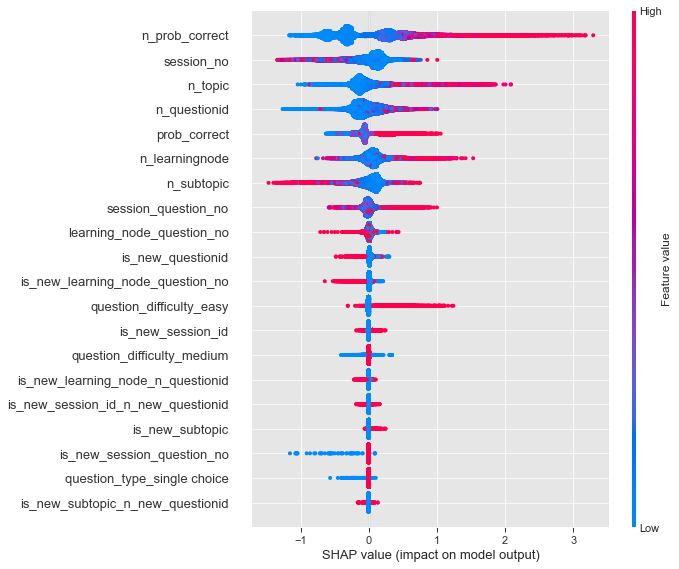

In [945]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_model_test[predictors])
shap.summary_plot(shap_values, data_model_test[predictors])

Pada hasil Shap diketahui secara vertikal fitur mana yang paling mempengaruhi hasil model sedangkan pada horizontal memberitahukan fitur tersebut lebih berpengaruh pada kelas + atau kelas -

# 5. Backtesting using Data Test (Out of Sample)

In [952]:
data_test = pd.read_csv('test.csv')
data_test.head()

,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,question_difficulty,question_number_of_choice,question_number_of_correct_choice,row_id
0,2348875,3206055652,2.0,1064573894,6164056362,1683819444,2226271822,Single choice,2,2,medium,4,1,0
1,2766044,2972889287,11.0,1737274108,6197171301,8772005155,8350981375,Single choice,6,2,medium,4,1,1
2,3604867,8630265714,4.0,2624511878,5665086549,1064446677,7911407965,Single choice,8,2,NaN,4,1,2
3,4061807,7315912009,10.0,147927464,5665086549,7469873307,2368078655,Single choice,7,1,NaN,4,1,3
4,5713467,7344767708,3.0,253258722,2774427363,3261917054,6616709393,Single choice,9,3,medium,4,1,4


In [955]:
user_id = []
session_id=[]
session_no=[]
topic=[]
sub_topic=[]
learning_node=[]
question_id=[]
question_type=[]
session_question_no=[]
learning_node_question_no=[]
question_difficulty=[]
question_number_of_choice=[]
#is_correct=[]
row_id=[]

#new columns
#feature engineering

is_new_session_id=[]

is_new_topic=[]
is_new_subtopic=[]
is_new_learningnode=[]
is_new_questionid=[]
is_new_session_question_no=[]
is_new_learning_node_question_no=[]

n_topic=[]
n_subtopic=[]
n_learningnode=[]
n_questionid=[]

#tambahan empty dictionary
session_question = collections.defaultdict(list)
learning_question= collections.defaultdict(list)

for i in tqdm(range(len(data_test.user_id.unique()))):
    df_user = data_test[data_test.user_id==data_test.user_id.unique()[i]]

    for j in range(df_user.shape[0]):
    
        user_id.append(df_user.user_id.iloc[j])
        session_no.append(df_user.session_no.iloc[j])
        
        #is_new_session
        if (df_user.session_id.iloc[j] in session_id):
            is_new_session_id.append(0)
        else:
            is_new_session_id.append(1)
    
        #is_new_topic
        if (df_user.topic.iloc[j] in topic):
            is_new_topic.append(0)
        else:
            is_new_topic.append(1)
        
        #is_new_subtopic
        if (df_user.sub_topic.iloc[j] in sub_topic):
            is_new_subtopic.append(0)
        else:
            is_new_subtopic.append(1)
        
        #is_new_learningnode
        if (df_user.learning_node.iloc[j] in learning_node):
            is_new_learningnode.append(0)
        else:
            is_new_learningnode.append(1)
        
        #is_new_questionid
        if (df_user.question_id.iloc[j] in question_id):
            is_new_questionid.append(0)
        else:
            is_new_questionid.append(1)
    
        #is_new_session_question_no
        key,value = df_user.session_id.iloc[j], df_user.session_question_no.iloc[j]   # Key and value present
        if key in session_question and value in session_question[key]:
            is_new_session_question_no.append(0)
        else:
            is_new_session_question_no.append(1)
        
        #is_new_learning_node_question_no
        key_1,value_1 = df_user.learning_node.iloc[j], df_user.learning_node_question_no.iloc[j]   # Key and value present
        if key_1 in learning_question and value_1 in learning_question[key_1]:
            is_new_learning_node_question_no.append(0)
        else:
            is_new_learning_node_question_no.append(1)
    
        #update dictionary
        session_question[df_user.session_id.iloc[j]].append(df_user.session_question_no.iloc[j])
        learning_question[df_user.learning_node.iloc[j]].append(df_user.learning_node_question_no.iloc[j])
    
        #old columns
        session_id.append(df_user.session_id.iloc[j])
        topic.append(df_user.topic.iloc[j])
        sub_topic.append(df_user.sub_topic.iloc[j])
        learning_node.append(df_user.learning_node.iloc[j])
        question_id.append(df_user.question_id.iloc[j])
        question_type.append(df_user.question_type.iloc[j])
        question_difficulty.append(df_user.question_difficulty.iloc[j])
        session_question_no.append(df_user.session_question_no.iloc[j])
        learning_node_question_no.append(df_user.learning_node_question_no.iloc[j])
        question_number_of_choice.append(df_user.question_number_of_choice.iloc[j])
        #is_correct.append(df_user.is_correct.iloc[j])
        row_id.append(df_user.row_id.iloc[j])
    
        #n_topic
        n_topic.append(len(Counter(topic).keys()))
        #n_subtopic
        n_subtopic.append(len(Counter(sub_topic).keys()))
        #n_learningnode
        n_learningnode.append(len(Counter(learning_node).keys()))
        #n_questionid
        n_questionid.append(len(Counter(question_id).keys()))
        
pd_cust = pd.DataFrame()
pd_cust['user_id']=user_id
pd_cust['session_id']=session_id
pd_cust['session_no']=session_no
pd_cust['topic']=topic
pd_cust['sub_topic']=sub_topic
pd_cust['learning_node']=learning_node
pd_cust['question_id']=question_id
pd_cust['question_type']=question_type
pd_cust['session_question_no']=session_question_no
pd_cust['learning_node_question_no']=learning_node_question_no
pd_cust['question_number_of_choice']=question_number_of_choice
pd_cust['question_difficulty']= question_difficulty


pd_cust['is_new_session_id']=is_new_session_id
pd_cust['is_new_topic']=is_new_topic
pd_cust['is_new_subtopic']=is_new_subtopic
pd_cust['is_new_learningnode']=is_new_learningnode
pd_cust['is_new_questionid']=is_new_questionid
pd_cust['is_new_session_question_no']= is_new_session_question_no
pd_cust['is_new_learning_node_question_no']=is_new_learning_node_question_no


pd_cust['n_topic']=n_topic
pd_cust['n_subtopic']=n_subtopic
pd_cust['n_learningnode']=n_learningnode
pd_cust['n_questionid']=n_questionid

pd_cust['row_id']=row_id

print(pd_cust.shape)
pd_cust

100%|█████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:27<00:00, 250.85it/s]


(7000, 24)


,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,question_number_of_choice,question_difficulty,is_new_session_id,is_new_topic,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,n_topic,n_subtopic,n_learningnode,n_questionid,row_id
0,2348875,3206055652,2.0,1064573894,6164056362,1683819444,2226271822,Single choice,2,2,4,medium,1,1,1,1,1,1,1,1,1,1,1,0
1,2766044,2972889287,11.0,1737274108,6197171301,8772005155,8350981375,Single choice,6,2,4,medium,1,1,1,1,1,1,1,2,2,2,2,1
2,3604867,8630265714,4.0,2624511878,5665086549,1064446677,7911407965,Single choice,8,2,4,NaN,1,1,1,1,1,1,1,3,3,3,3,2
3,4061807,7315912009,10.0,147927464,5665086549,7469873307,2368078655,Single choice,7,1,4,NaN,1,1,0,1,1,1,1,4,3,4,4,3
4,5713467,7344767708,3.0,253258722,2774427363,3261917054,6616709393,Single choice,9,3,4,medium,1,1,1,1,1,1,1,5,4,5,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,9986310194,3653399369,18.0,9892562260,5665086549,9065851221,4211231372,Single choice,1,1,5,NaN,1,0,0,0,0,1,0,1132,1228,3589,4825,6995
6996,9986414625,4689780633,1.0,9922825353,8640328279,1334771130,21101789,Single choice,6,1,4,medium,1,0,0,0,1,1,0,1132,1228,3589,4826,6996
6997,9989505176,6679766557,6.0,1937708227,2177007574,3886489050,6675622814,Single choice,14,2,5,medium,1,0,1,1,1,1,1,1132,1229,3590,4827,6997
6998,9995702673,3345433598,4.0,3132818026,9820886383,3734521556,8219418946,Single choice,14,2,4,medium,1,0,0,0,1,1,1,1132,1229,3590,4828,6998


In [956]:
pd_cust['is_new_session_id_n_new_topic']        = pd_cust['is_new_session_id'] & pd_cust['is_new_topic']
pd_cust['is_new_session_id_n_new_subtopic']     = pd_cust['is_new_session_id'] & pd_cust['is_new_subtopic']
pd_cust['is_new_session_id_n_new_learningnode'] = pd_cust['is_new_session_id'] & pd_cust['is_new_learningnode']
pd_cust['is_new_session_id_n_new_questionid']   = pd_cust['is_new_session_id'] & pd_cust['is_new_questionid']

pd_cust['is_new_topic_n_new_subtopic']          = pd_cust['is_new_topic'] & pd_cust['is_new_subtopic']
pd_cust['is_new_topic_n_new_learningnode']      = pd_cust['is_new_topic'] & pd_cust['is_new_learningnode']
pd_cust['is_new_topic_n_new_questionid']        = pd_cust['is_new_topic'] & pd_cust['is_new_questionid']

pd_cust['is_new_subtopic_n_new_learningnode']   = pd_cust['is_new_subtopic'] & pd_cust['is_new_learningnode']
pd_cust['is_new_subtopic_n_new_questionid']     = pd_cust['is_new_subtopic'] & pd_cust['is_new_questionid']

pd_cust['is_new_learning_node_n_questionid']    = pd_cust['is_new_learningnode'] & pd_cust['is_new_questionid']

In [957]:
pd_cust

,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,question_number_of_choice,question_difficulty,is_new_session_id,is_new_topic,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,n_topic,n_subtopic,n_learningnode,n_questionid,row_id,is_new_session_id_n_new_topic,is_new_session_id_n_new_subtopic,is_new_session_id_n_new_learningnode,is_new_session_id_n_new_questionid,is_new_topic_n_new_subtopic,is_new_topic_n_new_learningnode,is_new_topic_n_new_questionid,is_new_subtopic_n_new_learningnode,is_new_subtopic_n_new_questionid,is_new_learning_node_n_questionid
0,2348875,3206055652,2.0,1064573894,6164056362,1683819444,2226271822,Single choice,2,2,4,medium,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
1,2766044,2972889287,11.0,1737274108,6197171301,8772005155,8350981375,Single choice,6,2,4,medium,1,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1
2,3604867,8630265714,4.0,2624511878,5665086549,1064446677,7911407965,Single choice,8,2,4,NaN,1,1,1,1,1,1,1,3,3,3,3,2,1,1,1,1,1,1,1,1,1,1
3,4061807,7315912009,10.0,147927464,5665086549,7469873307,2368078655,Single choice,7,1,4,NaN,1,1,0,1,1,1,1,4,3,4,4,3,1,0,1,1,0,1,1,0,0,1
4,5713467,7344767708,3.0,253258722,2774427363,3261917054,6616709393,Single choice,9,3,4,medium,1,1,1,1,1,1,1,5,4,5,5,4,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,9986310194,3653399369,18.0,9892562260,5665086549,9065851221,4211231372,Single choice,1,1,5,NaN,1,0,0,0,0,1,0,1132,1228,3589,4825,6995,0,0,0,0,0,0,0,0,0,0
6996,9986414625,4689780633,1.0,9922825353,8640328279,1334771130,21101789,Single choice,6,1,4,medium,1,0,0,0,1,1,0,1132,1228,3589,4826,6996,0,0,0,1,0,0,0,0,0,0
6997,9989505176,6679766557,6.0,1937708227,2177007574,3886489050,6675622814,Single choice,14,2,5,medium,1,0,1,1,1,1,1,1132,1229,3590,4827,6997,0,1,1,1,0,0,0,1,1,1
6998,9995702673,3345433598,4.0,3132818026,9820886383,3734521556,8219418946,Single choice,14,2,4,medium,1,0,0,0,1,1,1,1132,1229,3590,4828,6998,0,0,0,1,0,0,0,0,0,0


In [958]:
pd_cust.to_csv('20210815_Datatest_RuangGuru_FeatureEng2.csv')

In [961]:
data_train = pd.read_csv('20210815_Datatest_RuangGuru_FeatureEng2.csv')
data_train

,Unnamed: 0,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,question_number_of_choice,question_difficulty,is_new_session_id,is_new_topic,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,n_topic,n_subtopic,n_learningnode,n_questionid,row_id,is_new_session_id_n_new_topic,is_new_session_id_n_new_subtopic,is_new_session_id_n_new_learningnode,is_new_session_id_n_new_questionid,is_new_topic_n_new_subtopic,is_new_topic_n_new_learningnode,is_new_topic_n_new_questionid,is_new_subtopic_n_new_learningnode,is_new_subtopic_n_new_questionid,is_new_learning_node_n_questionid
0,0,2348875,3206055652,2.0,1064573894,6164056362,1683819444,2226271822,Single choice,2,2,4,medium,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
1,1,2766044,2972889287,11.0,1737274108,6197171301,8772005155,8350981375,Single choice,6,2,4,medium,1,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1
2,2,3604867,8630265714,4.0,2624511878,5665086549,1064446677,7911407965,Single choice,8,2,4,NaN,1,1,1,1,1,1,1,3,3,3,3,2,1,1,1,1,1,1,1,1,1,1
3,3,4061807,7315912009,10.0,147927464,5665086549,7469873307,2368078655,Single choice,7,1,4,NaN,1,1,0,1,1,1,1,4,3,4,4,3,1,0,1,1,0,1,1,0,0,1
4,4,5713467,7344767708,3.0,253258722,2774427363,3261917054,6616709393,Single choice,9,3,4,medium,1,1,1,1,1,1,1,5,4,5,5,4,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,6995,9986310194,3653399369,18.0,9892562260,5665086549,9065851221,4211231372,Single choice,1,1,5,NaN,1,0,0,0,0,1,0,1132,1228,3589,4825,6995,0,0,0,0,0,0,0,0,0,0
6996,6996,9986414625,4689780633,1.0,9922825353,8640328279,1334771130,21101789,Single choice,6,1,4,medium,1,0,0,0,1,1,0,1132,1228,3589,4826,6996,0,0,0,1,0,0,0,0,0,0
6997,6997,9989505176,6679766557,6.0,1937708227,2177007574,3886489050,6675622814,Single choice,14,2,5,medium,1,0,1,1,1,1,1,1132,1229,3590,4827,6997,0,1,1,1,0,0,0,1,1,1
6998,6998,9995702673,3345433598,4.0,3132818026,9820886383,3734521556,8219418946,Single choice,14,2,4,medium,1,0,0,0,1,1,1,1132,1229,3590,4828,6998,0,0,0,1,0,0,0,0,0,0


<AxesSubplot:title={'center':'Kolom yang memiliki Null(1/24)'}>

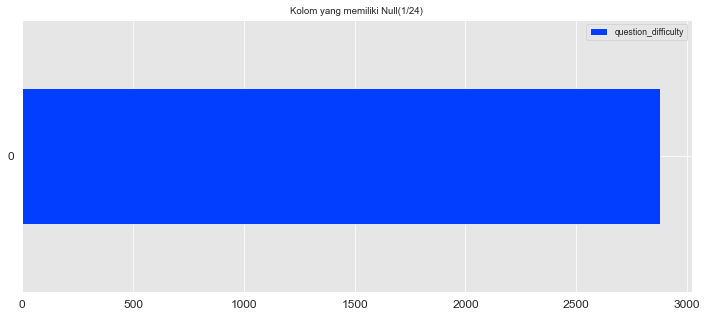

In [962]:
#hitung jumlah NULL dalam setiap kolom
# Count total NaN at each column in a DataFrame 
data_null = pd.DataFrame(data_train.isnull().sum())
data_null = data_null.transpose()
data_null_filter=data_null.loc[:, (data_null != 0).any(axis=0)]
data_null_filter.plot(kind='barh',title='Kolom yang memiliki Null(1/24)',fontsize=12)

In [963]:
data_train['question_difficulty'].fillna('medium', inplace=True)

In [964]:
data_train.isnull().sum()

Unnamed: 0                              0
user_id                                 0
session_id                              0
session_no                              0
topic                                   0
sub_topic                               0
learning_node                           0
question_id                             0
question_type                           0
session_question_no                     0
learning_node_question_no               0
question_number_of_choice               0
question_difficulty                     0
is_new_session_id                       0
is_new_topic                            0
is_new_subtopic                         0
is_new_learningnode                     0
is_new_questionid                       0
is_new_session_question_no              0
is_new_learning_node_question_no        0
n_topic                                 0
n_subtopic                              0
n_learningnode                          0
n_questionid                      

In [965]:
question_type        = pd.get_dummies(data_train.question_type, prefix='question_type')
question_difficulty  = pd.get_dummies(data_train.question_difficulty, prefix='question_difficulty')

In [966]:
data_train = pd.concat([data_train, question_type], axis=1)
data_train = pd.concat([data_train, question_difficulty], axis=1)

In [967]:
data_train = data_train.drop(['Unnamed: 0','session_id', 'topic', 'sub_topic', 
                              'learning_node', 'question_id', 'question_type',
                              'question_difficulty'] ,axis=1)

In [968]:
data_train.to_csv('20210815_Datatest_RuangGuru_FeatureEng2_cleaned.csv')

In [970]:
user_id = []
session_id=[]
session_no=[]
topic=[]
sub_topic=[]
learning_node=[]
question_id=[]
question_type=[]
session_question_no=[]
learning_node_question_no=[]
question_difficulty=[]
question_number_of_choice=[]
question_number_of_correct_choice=[]
#is_correct=[]
row_id=[]

#tambahan empty dictionary
n_topic_dict = collections.defaultdict(list)
n_subtopic_dict = collections.defaultdict(list)
n_learningnode_dict = collections.defaultdict(list)
n_questionid_dict = collections.defaultdict(list)
n_prob_correct_dict= collections.defaultdict(list)

n_topic=[]
n_subtopic=[]
n_learningnode=[]
n_questionid=[]
prob_correct=[]
n_prob_correct=[]

#for i in tqdm(range(5)):
for i in tqdm(range(len(data_test.user_id.unique()))):
    df_user = data_test[data_test.user_id==data_test.user_id.unique()[i]]

    for j in range(df_user.shape[0]):
    
        user_id.append(df_user.user_id.iloc[j])
        session_no.append(df_user.session_no.iloc[j])
    
        #old columns
        session_id.append(df_user.session_id.iloc[j])
        topic.append(df_user.topic.iloc[j])
        sub_topic.append(df_user.sub_topic.iloc[j])
        learning_node.append(df_user.learning_node.iloc[j])
        question_id.append(df_user.question_id.iloc[j])
        question_type.append(df_user.question_type.iloc[j])
        question_difficulty.append(df_user.question_difficulty.iloc[j])
        session_question_no.append(df_user.session_question_no.iloc[j])
        learning_node_question_no.append(df_user.learning_node_question_no.iloc[j])
        question_number_of_choice.append(df_user.question_number_of_choice.iloc[j])
        question_number_of_correct_choice.append(df_user.question_number_of_correct_choice.iloc[j])
        #is_correct.append(df_user.is_correct.iloc[j])
        row_id.append(df_user.row_id.iloc[j])
    
        #n_topic
        key,value = df_user.user_id.iloc[j], df_user.topic.iloc[j]   # Key and value present
        if key not in  n_topic_dict and value not in  n_topic_dict[key]:
            n_topic.append(1)
            
        elif key in  n_topic_dict and value not in  n_topic_dict[key]:
            n_topic.append(len(Counter(n_topic_dict[key]).keys())+1)
        
        elif key in  n_topic_dict and value in  n_topic_dict[key]:
            n_topic.append(len(Counter(n_topic_dict[key]).keys()))
            
        #n_subtopic
        key1,value1 = df_user.user_id.iloc[j], df_user.sub_topic.iloc[j]   # Key and value present
        if key1 not in  n_subtopic_dict and value1 not in  n_subtopic_dict[key1]:
            n_subtopic.append(1)
            
        elif key1 in  n_subtopic_dict and value1 not in  n_subtopic_dict[key1]:
            n_subtopic.append(len(Counter(n_subtopic_dict[key1]).keys())+1)
        
        elif key1 in  n_subtopic_dict and value1 in  n_subtopic_dict[key1]:
            n_subtopic.append(len(Counter(n_subtopic_dict[key1]).keys()))
            
        #n_learningnode
        key2,value2 = df_user.user_id.iloc[j], df_user.learning_node.iloc[j]   # Key and value present
        if key2 not in  n_learningnode_dict and value2 not in  n_learningnode_dict[key2]:
            n_learningnode.append(1)
            
        elif key2 in  n_learningnode_dict and value2 not in  n_learningnode_dict[key2]:
            n_learningnode.append(len(Counter(n_learningnode_dict[key2]).keys())+1)
        
        elif key2 in  n_learningnode_dict and value2 in  n_learningnode_dict[key2]:
            n_learningnode.append(len(Counter(n_learningnode_dict[key2]).keys()))
            
        #n_questionid
        key3,value3 = df_user.user_id.iloc[j], df_user.question_id.iloc[j]   # Key and value present
        if key3 not in  n_questionid_dict and value3 not in  n_questionid_dict[key3]:
            n_questionid.append(1)
            
        elif key3 in  n_questionid_dict and value3 not in  n_questionid_dict[key3]:
            n_questionid.append(len(Counter(n_questionid_dict[key3]).keys())+1)
        
        elif key3 in  n_questionid_dict and value3 in  n_questionid_dict[key3]:
            n_questionid.append(len(Counter(n_questionid_dict[key3]).keys()))
            
        #n_prob_correct
        key4,value4 = df_user.user_id.iloc[j], df_user.question_id.iloc[j]   # Key and value present
        if key4 not in n_prob_correct_dict and value4 not in  n_prob_correct_dict[key4]:
            n_prob_correct.append(df_user.question_number_of_correct_choice.iloc[j]/df_user.question_number_of_choice.iloc[j])
            
        elif key4 in n_prob_correct_dict and value4 not in n_prob_correct_dict[key4]:
            n_prob_correct.append(df_user.question_number_of_correct_choice.iloc[j]/df_user.question_number_of_choice.iloc[j])
        
        elif key4 in  n_prob_correct_dict and value4 in  n_prob_correct_dict[key4]:
            temp_list =  n_prob_correct_dict[key4]
            n_prob_correct.append((temp_list.count(df_user.question_id.iloc[j])+1)/df_user.question_number_of_choice.iloc[j])    
            
        #prob_correct
        prob_correct.append(df_user.question_number_of_correct_choice.iloc[j]/df_user.question_number_of_choice.iloc[j])
        
        #update dictionary
        n_topic_dict[df_user.user_id.iloc[j]].append(df_user.topic.iloc[j])
        n_subtopic_dict[df_user.user_id.iloc[j]].append(df_user.sub_topic.iloc[j])
        n_learningnode_dict[df_user.user_id.iloc[j]].append(df_user.learning_node.iloc[j])
        n_questionid_dict[df_user.user_id.iloc[j]].append(df_user.question_id.iloc[j])
        n_prob_correct_dict[df_user.user_id.iloc[j]].append(df_user.question_id.iloc[j])
        
        
pd_cust = pd.DataFrame()
pd_cust['user_id']=user_id
pd_cust['session_id']=session_id
pd_cust['session_no']=session_no
pd_cust['topic']=topic
pd_cust['sub_topic']=sub_topic
pd_cust['learning_node']=learning_node
pd_cust['question_id']=question_id
pd_cust['question_type']=question_type
pd_cust['session_question_no']=session_question_no
pd_cust['learning_node_question_no']=learning_node_question_no
pd_cust['question_number_of_choice']=question_number_of_choice
pd_cust['question_difficulty']= question_difficulty

pd_cust['n_topic']=n_topic
pd_cust['n_subtopic']=n_subtopic
pd_cust['n_learningnode']=n_learningnode
pd_cust['n_questionid']=n_questionid
pd_cust['prob_correct']=prob_correct
pd_cust['n_prob_correct']=n_prob_correct

pd_cust['row_id']=row_id

print(pd_cust.shape)
pd_cust

100%|█████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:09<00:00, 723.06it/s]

(7000, 19)


,user_id,session_id,session_no,topic,sub_topic,learning_node,question_id,question_type,session_question_no,learning_node_question_no,question_number_of_choice,question_difficulty,n_topic,n_subtopic,n_learningnode,n_questionid,prob_correct,n_prob_correct,row_id
0,2348875,3206055652,2.0,1064573894,6164056362,1683819444,2226271822,Single choice,2,2,4,medium,1,1,1,1,0.250000,0.250000,0
1,2766044,2972889287,11.0,1737274108,6197171301,8772005155,8350981375,Single choice,6,2,4,medium,1,1,1,1,0.250000,0.250000,1
2,3604867,8630265714,4.0,2624511878,5665086549,1064446677,7911407965,Single choice,8,2,4,NaN,1,1,1,1,0.250000,0.250000,2
3,4061807,7315912009,10.0,147927464,5665086549,7469873307,2368078655,Single choice,7,1,4,NaN,1,1,1,1,0.250000,0.250000,3
4,5713467,7344767708,3.0,253258722,2774427363,3261917054,6616709393,Single choice,9,3,4,medium,1,1,1,1,0.250000,0.250000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,9986310194,3653399369,18.0,9892562260,5665086549,9065851221,4211231372,Single choice,1,1,5,NaN,1,1,1,1,0.200000,0.200000,6995
6996,9986414625,4689780633,1.0,9922825353,8640328279,1334771130,21101789,Single choice,6,1,4,medium,1,1,1,1,0.250000,0.250000,6996
6997,9989505176,6679766557,6.0,1937708227,2177007574,3886489050,6675622814,Single choice,14,2,5,medium,1,1,1,1,0.200000,0.200000,6997
6998,9995702673,3345433598,4.0,3132818026,9820886383,3734521556,8219418946,Single choice,14,2,4,medium,1,1,1,1,0.250000,0.250000,6998


In [971]:
data_initial = pd.read_csv('20210815_Datatest_RuangGuru_FeatureEng2_cleaned.csv')
data_initial = data_initial.drop(['n_topic','n_subtopic','n_learningnode','n_questionid'] ,axis=1)
list_n_topic = pd_cust.n_topic.tolist()
list_n_subtopic = pd_cust.n_subtopic.tolist()
list_n_learningnode = pd_cust.n_learningnode.tolist()
list_n_questionid = pd_cust.n_questionid.tolist()
list_prob_correct = pd_cust.prob_correct.tolist()
list_n_prob_correct = pd_cust.n_prob_correct.tolist()
data_initial['n_topic']=list_n_topic
data_initial['n_subtopic']=list_n_subtopic
data_initial['n_learningnode']=list_n_learningnode
data_initial['n_questionid']=list_n_questionid
data_initial['prob_correct']=list_prob_correct
data_initial['n_prob_correct']=list_n_prob_correct
data_initial.to_csv('20210815_Datatest_RuangGuru_FeatureEng2_cleaned_newver.csv')

__Backtesting__

In [990]:
datatest

,Unnamed: 0,Unnamed: 0.1,user_id,session_no,session_question_no,learning_node_question_no,question_number_of_choice,is_new_session_id,is_new_topic,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,row_id,is_new_session_id_n_new_topic,is_new_session_id_n_new_subtopic,is_new_session_id_n_new_learningnode,is_new_session_id_n_new_questionid,is_new_topic_n_new_subtopic,is_new_topic_n_new_learningnode,is_new_topic_n_new_questionid,is_new_subtopic_n_new_learningnode,is_new_subtopic_n_new_questionid,is_new_learning_node_n_questionid,question_type_Multi choice,question_type_Single choice,question_difficulty_easy,question_difficulty_hard,question_difficulty_hots,question_difficulty_medium,n_topic,n_subtopic,n_learningnode,n_questionid,prob_correct,n_prob_correct
0,0,0,2348875,2.0,2,2,4,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000
1,1,1,2766044,11.0,6,2,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000
2,2,2,3604867,4.0,8,2,4,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000
3,3,3,4061807,10.0,7,1,4,1,1,0,1,1,1,1,3,1,0,1,1,0,1,1,0,0,1,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000
4,4,4,5713467,3.0,9,3,4,1,1,1,1,1,1,1,4,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,6995,6995,9986310194,18.0,1,1,5,1,0,0,0,0,1,0,6995,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0.200000,0.200000
6996,6996,6996,9986414625,1.0,6,1,4,1,0,0,0,1,1,0,6996,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000
6997,6997,6997,9989505176,6.0,14,2,5,1,0,1,1,1,1,1,6997,0,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1,1,1,1,0.200000,0.200000
6998,6998,6998,9995702673,4.0,14,2,4,1,0,0,0,1,1,1,6998,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000


In [1039]:
data_backtest = pd.read_csv('20210815_Datatest_RuangGuru_FeatureEng2_cleaned_newver.csv')
data_backtest.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'user_id', 'session_no',
       'session_question_no', 'learning_node_question_no',
       'question_number_of_choice', 'is_new_session_id', 'is_new_topic',
       'is_new_subtopic', 'is_new_learningnode', 'is_new_questionid',
       'is_new_session_question_no', 'is_new_learning_node_question_no',
       'row_id', 'is_new_session_id_n_new_topic',
       'is_new_session_id_n_new_subtopic',
       'is_new_session_id_n_new_learningnode',
       'is_new_session_id_n_new_questionid', 'is_new_topic_n_new_subtopic',
       'is_new_topic_n_new_learningnode', 'is_new_topic_n_new_questionid',
       'is_new_subtopic_n_new_learningnode',
       'is_new_subtopic_n_new_questionid', 'is_new_learning_node_n_questionid',
       'question_type_Multi choice', 'question_type_Single choice',
       'question_difficulty_easy', 'question_difficulty_hard',
       'question_difficulty_hots', 'question_difficulty_medium', 'n_topic',
       'n_subtopic', 'n_learningnode', '

In [1046]:
predictors =['n_prob_correct',
 'prob_correct',
 'is_new_questionid',
 'n_topic',
 'session_no',
 'n_learningnode',
 'n_questionid',
 'question_number_of_choice',
 'learning_node_question_no',
 'is_new_learning_node_question_no',
 'session_question_no',
 'n_subtopic',
 'is_new_session_id',
 'question_difficulty_easy',
 'question_difficulty_medium',
 'is_new_learning_node_n_questionid',
 'is_new_session_id_n_new_questionid',
 'is_new_session_id_n_new_learningnode',
 'is_new_session_question_no',
 'is_new_learningnode',
 'question_type_Single choice',
 'is_new_subtopic_n_new_learningnode',
 'is_new_subtopic_n_new_questionid',
 'is_new_subtopic']

target_label = 'is_correct'

In [1047]:
model_path_XGBoost = '20210815_model_ruangguru_xgboost_Voting_selector.pkl'

In [1048]:
roc_train_xgboost = "%s_performance_roc_curve_data_backtest_ruangguru_xgboost_Voting_selector.png" % str(date.today().strftime("%Y%m%d"))
train_path_xgboost = "%s_predict_result_data_backtest_ruangguru_xgboost_Voting_selector.csv" % str(date.today().strftime("%Y%m%d"))

In [1049]:
def model_predict(data_test, predictors, model_path, file_path):
    ## LOAD MODEL
    model = joblib.load(model_path)

    ## CALCULATE BEHAVIOUR SCORING
    data_test['is_correct'] = model.predict_proba(data_test[predictors])[:,1]
    data_test.to_csv(file_path, index=False)
    
    return data_test

In [1050]:
train_performance_XGBoost = model_predict(data_backtest, predictors, model_path_XGBoost, train_path_xgboost)

In [1051]:
train_performance_XGBoost

,Unnamed: 0,Unnamed: 0.1,user_id,session_no,session_question_no,learning_node_question_no,question_number_of_choice,is_new_session_id,is_new_topic,is_new_subtopic,is_new_learningnode,is_new_questionid,is_new_session_question_no,is_new_learning_node_question_no,row_id,is_new_session_id_n_new_topic,is_new_session_id_n_new_subtopic,is_new_session_id_n_new_learningnode,is_new_session_id_n_new_questionid,is_new_topic_n_new_subtopic,is_new_topic_n_new_learningnode,is_new_topic_n_new_questionid,is_new_subtopic_n_new_learningnode,is_new_subtopic_n_new_questionid,is_new_learning_node_n_questionid,question_type_Multi choice,question_type_Single choice,question_difficulty_easy,question_difficulty_hard,question_difficulty_hots,question_difficulty_medium,n_topic,n_subtopic,n_learningnode,n_questionid,prob_correct,n_prob_correct,behav_score,is_correct
0,0,0,2348875,2.0,2,2,4,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000,0.470884,0.470884
1,1,1,2766044,11.0,6,2,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000,0.485793,0.485793
2,2,2,3604867,4.0,8,2,4,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000,0.566418,0.566418
3,3,3,4061807,10.0,7,1,4,1,1,0,1,1,1,1,3,1,0,1,1,0,1,1,0,0,1,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000,0.459828,0.459828
4,4,4,5713467,3.0,9,3,4,1,1,1,1,1,1,1,4,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000,0.598341,0.598341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,6995,6995,9986310194,18.0,1,1,5,1,0,0,0,0,1,0,6995,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0.200000,0.200000,0.338474,0.338474
6996,6996,6996,9986414625,1.0,6,1,4,1,0,0,0,1,1,0,6996,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000,0.521862,0.521862
6997,6997,6997,9989505176,6.0,14,2,5,1,0,1,1,1,1,1,6997,0,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1,1,1,1,0.200000,0.200000,0.360577,0.360577
6998,6998,6998,9995702673,4.0,14,2,4,1,0,0,0,1,1,1,6998,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0.250000,0.250000,0.611629,0.611629


In [1059]:
train_performance_XGBoost=train_performance_XGBoost[['row_id','is_correct']]
train_performance_XGBoost

,row_id,is_correct
0,0,0.470884
1,1,0.485793
2,2,0.566418
3,3,0.459828
4,4,0.598341
...,...,...
6995,6995,0.338474
6996,6996,0.521862
6997,6997,0.360577
6998,6998,0.611629


# Save hasil backtesting

In [1062]:
train_performance_XGBoost.to_csv('submission.csv')

In [1065]:
train_performance_XGBoost

,row_id,is_correct
0,0,0.470884
1,1,0.485793
2,2,0.566418
3,3,0.459828
4,4,0.598341
...,...,...
6995,6995,0.338474
6996,6996,0.521862
6997,6997,0.360577
6998,6998,0.611629


# Saran penambahan fitur pada model untuk menambah performansi

* __is sub-Topic=5665086549__ (paling banyak muncul pada dataset)